# Модельки
Что присутствует в данном ноутбуке:
* Предобработка данных 
* Работа с пропущенными переменными
* Обучение и оценка моделей двух видов: линейные (**LinearRegression**, **Lasso**, **Ridge**, **ElasticNet**) и деревянные (**RandomForest** и градиентный бустинг в лице **CatBoost**)
* Отбор признаков и тюнинг параметров
* Кросс-валидация
* Построение интерпретаций (начиная с анализа оценок коэффициентов, заканчивая **permutation_importance** и **SHAP Values**), анализ и обсуждение полученных результатов

## Библиотеки

In [1]:
# Стандартный стэк
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Игнорирование предупреждений
from pandas.core.common import SettingWithCopyWarning
import warnings

# Препроцессинг
import sklearn.impute
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

# Метрики, кросс-валидация, отбор признаков
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.inspection import permutation_importance

# Модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import catboost as ctb

# Интерпретации и гипотезы
import scipy
import shap

## Данные

На вход имеем датафрейм с информацией об объявлениях о продаже квартир, обработанный в первом ноутбуке, дополненный географическими признаками из второго.

In [2]:
data_full = pd.read_csv('data3.csv', index_col = 0)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3309 entries, 0 to 3308
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_c                        2403 non-null   float64
 1   price                       3309 non-null   float64
 2   floor                       3309 non-null   float64
 3   max_floor                   3309 non-null   float64
 4   year                        3112 non-null   float64
 5   type                        3309 non-null   object 
 6   total_square                3309 non-null   float64
 7   kitchen_square              2018 non-null   float64
 8   living_square               1030 non-null   float64
 9   rooms                       3309 non-null   object 
 10  toilet                      2641 non-null   object 
 11  view                        2049 non-null   object 
 12  balcony                     3309 non-null   int64  
 13  renovation                  2709 

## Развернутое описание происходящего далее


### Метрика

Как обсуждалось ранее, в качестве объясняемой перменной в моделях будет использоваться логарифм цены квартиры, указанной в объявлении, так как логарифмирование приводит к более симметричному распределению, у которого нормально распределены статистики. Помимо этого, среднее и медиана по выборке почти совпадают для логарифма цены, так что можно было попробовать в роли оптимизационной метрики использовать среднюю абсолютную ошибку (**MAE**). Однако хочется сильнее наказывать модели за чересчур высокие отклонения от фактических цен, тогда как какие-то минимальные ошибки в цене при поставленной задаче менее важны чем большие, и кажется, что есть ряд наблюдений с очень низкими ценами и очень высокими стоимостями, подозрительно напоминающие выбросы, которые, тем не менее, тоже хотелось бы удачно предсказывать, так что в качестве метрики качества выбрана среднеквадратическая ошибка (**MSE**), также параллельно с ней будем сравнивать скорректированный коэффициент детерминации (**R2_adj**).

### Кросс-валидация

Так как в работе используются кросс-секционные данные без какой-либо временной структуры, кросс-валидацию будем проводить стандартным способ с разбиением на *n* фолдов, оубчением на *n-1* и предсказанием на оставшемся, для которого расчитываются тестовые метрики. Перед этим отделим от выборки часть в 309 наблюдений для валидационных целей (подбор гиперпараметров и отбор признаков), оставив для кросс-валидации ровно **3000** наблюдений. Поскольку данных не так много, а отнимать большую долю выборки при обучении не хочется, в качестве n выбрано **10**. Изначально я думал на дем, чтобы повторять кросс-валидацию дважды для разных *random_state* при разбиениях, но такой подход очевидно занимает вдвое больше времени, что уже чересчур долго, так что пришлось отказаться.

### Заполнение пропусков

Среди первых 30 признаков есть определенное число пропусков, заполнять которые будем простыми *imputer*-ами двумя разными способами для числовых признаков: **средним** и **медианой**; и **наиболее часто встречающимся значением** для категориальных переменных, не забывая ввести дамми на то, было ли значение для данного объекта пропущено. Реализация представлена в классе **filler**, обучаем *imputer* каждый раз на трейне, трансформируя и его, и тест.

### Количество комнат

Напомню, что переменная, отвечающая за количество комнат в квартире, на данный момент представлена как строковая, так как среди всех комнат есть не только количественная часть (от 1 до 5), но и квартиры свободной планировки и студии, помеченные маркерами **К** и **С** соответственно. В голову приходят четыре варианта того, каким образом подавать такую переменную на вход регрессиям:
* Оставить все как есть и рассматривать комнату как категориальный признак (очевидно, что тогда для модели недоступна логика численного сравнения: 5 точно меньше 6, но больше ли 5, чем **С**, непонятно).
* Количество комнат в проблемных (**С** и **К**) квартирах приравнять к 0 и ввести две дамми по названиям соответственно. 
* Присвоить проблемным квартирам количество комнат, сравнивая средние площади в *каждой из проблемных групп* со средними площадями по комнатным квартирам в выборке и находя наиболее похожие.
* Присвоить проблемным квартирам количество комнат, сравнивая площадь *каждой отдельно взятой* квартиры со средними площадями по комнатным квартирам в выборке и находя наиболее похожие. 

Для третьего и четвертого вариантов добавляется точно такая же дамми, как и во втором пункте. Очевидно, что поиск среднего при этом должен осуществляться только на обучающей части выборки, чтобы избежать ликов.

### Препроцессинг и категориальные переменные

Для линейных моделей попробуем включать числовые признаки как в том виде, котором они представлены сейчас, так и в масштабированном с помощью **StandardScaler** и **MinMaxScaler** представлении . Категориальные переменные будут обработаны при помощи **OneHotEncoding** для всех линейных моделей. Поскольку **CatBoost** поддерживает строковые переменные в том виде, котором они представлены на данный момент, для него *ohe* не понадобится. Так как в переменных *living_square* и *ceiling* слишком много пропусков, их использовать в моделях не будем.

### Отбор признаков
#### Линейный регрессии
Для линейных моделей отбор признаков будет происходить с помощью следующего жадного алгоритма (пока позволяют мощности и модели не сложные, почему бы и нет). Будем перебирать по-одному все признаки, поочередно добавляя их в регрессию и рассчитывая **MSE** на валидационном сете. Далее включаем в регрессию ту объясняющую переменную, метрика для которой на данном этапе оказалась минимальной, таким образом с шагом 1 постепенно переходя от модели с одной переменной до модели, включающей все возможные переменные, находящиеся в порядке их поочередного включения. 

Здесь можно поспорить о том, нужно ли продолжать оценивать регрессии, даже когда ошибка начинает только увеличиваться с включением новых признаков, но в таком случае могут быть проигнорированы потенциальные ситуации, когда метрика не уменьшается несколько шагов подряд, и мы решаем прекратить перебор, в то время как включение определенного числа новых признаков может привести улучшению, а так как вычислительная нагрузка при расчете линейных моделей не слишком высока и ограничений на время обучения нет, можно попробовать перебирать полностью.

Вообще было бы здорово включать поочередно не по одной переменной, а комбинации, например, из двух и трех, но в таком случае очевидно призойдет гигантский прирост общего числа комбинаций, которые нужно будет проверить:

* С $\sum \limits _{i=1} ^{n} i$, где n - общее число признаков (так как на каждом шаге уже включенные в регрессию переменные проверять заново не имеет смысла), когда выбираем по-одному
* До $\sum \limits _{i=1} ^{n/2} C^{2}_{n-2*(i-1)}$, где $C^{k}_{m}$ - число сочетаний из m по k, когда выбираем по 2 сразу

Что для n = 90 приведет к увеличению набора возможных комбинаций в ~15 раз, так что выбирать будем все-таки по одному признаку, что на самом деле, тоже занимает значительное количество времени.
#### Деревянные модели
Для случайного леса отбор переменных будем производить следующим образом. Сначала обучаем модель на всех признаках для каждого фолда из 10, на каждом шаге получая важности с помощью метода *feature_importances_*. После того, как прошли по всем фолдам, усредняем полученные значения, и по этому усреднению находим признаки, которые проходят заданный порог важности. Затем снова персчитываем модель с новыми фичами для всех фолдов и получаем средние важности. Процедуру повторяем до тех пор, пока на каком-то шаге выбранный сет признаков не будет совпадать с сетом на предыдущем шаге, в таком случае завершаем перебор и обучение.

Для градиентного бустинга схема отбора признаков аналогична предыдущей, за исключением того, что вместо метода *feature_importances_*
будем использовать *permutation_importance*,  реализованный в **sklearn.inspection**, который в общем случае должен точнее расчитывать важности по сравнению с *impurity-based* важностями. Так как его вычисление может быть довольно времязатратно, ограничимся десятью повторениями.

Расчет важностей происходит на отдельном валидационном сете, который не представлен в обучающей выборке.

## Реализация
Попробую сразу ответить на вопрос, почему весь процесс обучения, получения предсказаний и отбора признаков не реализован в виде пайплайнов, а вместо этого написан руками (каюсь, не всегда удачно), а также зачем в коде нужно было переизобретать велосипед. Во-первых, я не смог быстро найти, как можно реализовать кастомные преобразования столбцов в **sklearn.pipeline** (тем не менее, это безусловно можно сделать), которые были необходимы для расчета комнатности квартир. 

Так как долго искать не хотелось, а, во-вторых, было желание разобраться с тем, как будет происходить кросс-валидация и какие метрики считать, а какие нет, также желание добавить при обучении пару различных фич от себя и в целом хоть сколько-то самостоятельно контролировать и автоматизировать процесс, пришлось писать реализацию задуманного для линейных моделей самому. Так как код для обучения деревьев и бустингов являлся практически построчным копипастом кода для линейных регрессий, останавливаться было поздно, и я решил добить все руками.

## Функции и классы

Описанное выше представлено в 4 функциях и одном классе:

1. **filler** для заполнения пропусков
2. **processing** для предобработки
3. **linear_model** для обучения линейных моделей
4. **forest_model** для обучения случайного леса
5. **boosting_model** для обучения градиентного бустинга

Все они находятся в файле **housing_3_functions.py**, где, помимо их кода, содержатся комментарии к тому, что происходит внутри него. Я старался писать для каждой из функций краткую документацию, описывающую аргументы, внутренние составляющие и непосредственное назначение, а также комментарии по ходу написания кода.

In [3]:
from housing_3_functions import *

## Обучение моделей

Первым делом подготовим данные: уберем лишние переменные, добавим логарифмы площадей, распределим признаки по порядку (сначала числовые, потом категориальные), разделим выборку на обучающаю и валидационную части.

In [4]:
data_model = data_full.copy()
data_model = data_model.drop(['id_c', 'living_square', 'ceiling', 'consultant', 'name', 'address', 'description', \
                                'street', 'number', 'id_a', ], axis = 1)

data_model['total_log'] = np.log(data_model['total_square'])
data_model['kitchen_log'] = np.log(data_model['kitchen_square'])

data_model = data_model.loc[:, data_model.columns \
[list(map(lambda x: x not in ['type', 'rooms', 'toilet', 'view', 'renovation', 'elevator', 'building', \
                              'overlap', 'parking', 'area'], data_model.columns.tolist()))].tolist() + \
                ['type', 'rooms', 'toilet', 'view', 'renovation', 'elevator', 'building', 'overlap', 'parking', 'area']]


data_train, data_test = train_test_split(data_model, test_size = 309, shuffle = True, random_state = 42)

Поиск гиперпараметров для случайного леса и бустинга будем проводить с помощью рукописного *RandomSearchCV* (поиск по сетке, к сожалению, позволить себе не можем), так что создаем две таблицы со случайно сгенерированными параметрами:
*choices* для случайного леса, *choices_bstr* для бустинга. 

Как показала практика (отдельно считал линейные модели с разным значением, но не буду отдельно приводить вычисления с ними, чтобы не сликшом засорять результаты), для **Lasso**, **Ridge** и **ElasticNet**, оптимальное значение параметра *alpha* = 0.001. Для **ElasticNet** попробуем пару разных значения *l1-меры* (0.25, 0.5, 0.75).

In [5]:
### Гиперпараметры леса
choices = pd.DataFrame(index = range(0, 1000, 1), columns = ['n_estimators',
                                                            'max_depth',
                                                            'min_samples_split',
                                                            'min_samples_leaf',
                                                            'max_features',
                                                            'max_leaf_nodes',
                                                            'bootstrap',
                                                            'max_samples',
                                                            'threshold'])
# 'special' for None
choices['n_estimators'] = np.random.RandomState(42).choice([100, 300, 500, 700, 1000]*200, 1000, replace = False)
choices['max_depth'] = np.random.RandomState(43).choice([2, 4, 6, 8, 10]*200, 1000, replace = False)
choices['min_samples_split'] = np.random.RandomState(44).choice([2, 5, 10, 20, 40]*200, 1000, replace = False)
choices['min_samples_leaf'] = np.random.RandomState(45).choice([1, 2, 5, 10, 20]*200, 1000, replace = False)
choices['max_features'] = np.random.RandomState(46).choice([0.7, 'log2', 'sqrt', 'auto']*250, 1000, replace = False)
choices['max_leaf_nodes'] = np.random.RandomState(47).choice([5, 10, 20, 'special']*250, 1000, replace = False)
choices['bootstrap'] = np.random.RandomState(48).choice([True]*800 + [False]*200, 1000, replace = False)
choices['max_samples'] = np.random.RandomState(49).choice([0.5, 0.7, 0.9, 'special']*250, 1000, replace = False)
choices['threshold'] = np.random.RandomState(50).choice([0.05, 0.01, 0.005, 0.001]*250, 1000, replace = False)

choices.loc[~choices.max_features.str.contains('log2|sqrt|auto'), 'max_features'] = \
choices.loc[~choices.max_features.str.contains('log2|sqrt|auto'), 'max_features'].astype(np.float64)
choices.loc[choices.max_leaf_nodes != 'special', 'max_leaf_nodes'] = \
choices.loc[choices.max_leaf_nodes != 'special', 'max_leaf_nodes'].astype(np.int64)
choices.loc[choices.max_samples != 'special', 'max_samples'] = \
choices.loc[choices.max_samples != 'special', 'max_samples'].astype(np.float64)

### Гиперпараметры бустинга
choices_bstr = pd.DataFrame(index = range(0, 500, 1), columns = ['iterations', 
                                                                 'depth',  
                                                                 'learning_rate', 
                                                                 'random_strength',  
                                                                 'bagging_temperature', 
                                                                 'border_count',  
                                                                 'l2_leaf_reg',  
                                                                 'grow_policy',  
                                                                 'threshold'])
choices_bstr['iterations'] = np.random.RandomState(42).choice([250, 500, 1000, 1500]*125, 500, replace = False)
choices_bstr['depth'] = np.random.RandomState(43).choice([2, 4, 6, 8]*125, 500, replace = False)
choices_bstr['learning_rate'] = np.random.RandomState(44).choice([0.001, 0.01, 0.1, 0.2, 0.3]*100, 500, replace = False)
choices_bstr['random_strength'] = np.random.RandomState(45).choice([0, 0.3, 0.6, 1]*125, 500, replace = False)
choices_bstr['bagging_temperature'] = np.random.RandomState(46).choice([0, 0.7, 0.9, 1]*125, 500, replace = False)
choices_bstr['border_count'] = np.random.RandomState(47).choice([60, 128, 200, 254]*125, 500, replace = False)
choices_bstr['l2_leaf_reg'] = np.random.RandomState(48).choice([1, 3, 5, 10]*125, 500, replace = False)
choices_bstr['grow_policy'] = np.random.RandomState(49).choice(['SymmetricTree', 'Depthwise']*250, 500, replace = False)
choices_bstr['threshold'] = np.random.RandomState(50).choice([0.01, 0.005, 0.001, 0.0005]*125, 500, replace = False)

Создаем также две пустых таблички с индексами наблюдений, в которые во время обучения будут записываться предсказания на тестовых фолдах.

In [6]:
predictions = pd.DataFrame(index = data_train.index)
next_preds = -1

predictions_bstr = pd.DataFrame(index = data_train.index)
next_preds_bstr = -1

Запускаем перебор для всех моделей (Это надолго). У **Lasso** и **ElasticNet** часто не сходится покоординатный спуск, так что увеличиваем для них максимальное число итераций оптимизационного алгоритма.

In [1091]:
%%time
### Линейные
results_linear = linear_model('linear')
results_linear_mm = linear_model('linear', scaler = 'minmax')
results_linear_ss = linear_model('linear', scaler = 'standard')

results_ridge = linear_model('ridge')
results_ridge_mm = linear_model('ridge', scaler = 'minmax')
results_ridge_ss = linear_model('ridge', scaler = 'standard')

results_lasso = linear_model('lasso', iters = 4000)
results_lasso_mm = linear_model('lasso', scaler = 'minmax', iters = 4000)
results_lasso_ss = linear_model('lasso', scaler = 'standard', iters = 4000)

results_net = linear_model('elastic_net', iters = 5000)
results_net_mm = linear_model('elastic_net', scaler = 'minmax', iters = 5000)
results_net_ss = linear_model('elastic_net', scaler = 'standard', iters = 5000)

# Дополнительные вычисления для Elastic_net (только для неотмасшбатированных или стандартизированных с standard_scaler)
results_net_ss075 = linear_model('elastic_net', scaler = 'standard', iters = 5000, l1_ratio = 0.75)
results_net_ss025 = linear_model('elastic_net', scaler = 'standard', iters = 5000, l1_ratio = 0.25)
results_net075 = linear_model('elastic_net', scaler = None, iters = 5000, l1_ratio = 0.75)
results_net025 = linear_model('elastic_net', scaler = None, iters = 5000, l1_ratio = 0.25)

### Лес
starter = forest_model(threshold = 0.001)
for er in choices.index:
    if choices.loc[er, 'max_leaf_nodes'] == 'special':
        b = None
    else:
        b = choices.loc[er, 'max_leaf_nodes']
    if choices.loc[er, 'max_samples'] == 'special':
        c = None 
    else:
        c = choices.loc[er, 'max_samples']
    starter = pd.concat([starter, forest_model(n_estimators = choices.loc[er, 'n_estimators'],
                                               max_depth = choices.loc[er, 'max_depth'],
                                               min_samples_split = choices.loc[er, 'min_samples_split'],
                                               min_samples_leaf = choices.loc[er, 'min_samples_leaf'],
                                               max_features = choices.loc[er, 'max_features'],
                                               max_leaf_nodes = b,
                                               bootstrap = choices.loc[er, 'bootstrap'],
                                               max_samples = c,
                                               threshold = choices.loc[er, 'threshold'],
                                               cv = True)], axis = 0)

### Бустинг
starter_bstr = boosting_model(threshold = 0.0001)
for er in choices_bstr.index:
    starter_bstr = pd.concat([starter_bstr, boosting_model(iterations = choices_bstr.loc[er, 'iterations'], 
                                                           depth = choices_bstr.loc[er, 'depth'], 
                                                           learning_rate = choices_bstr.loc[er, 'learning_rate'], 
                                                           random_strength = choices_bstr.loc[er, 'random_strength'], 
                                                           bagging_temperature = \
                                                           choices_bstr.loc[er, 'bagging_temperature'], 
                                                           border_count = choices_bstr.loc[er, 'border_count'], 
                                                           l2_leaf_reg = choices_bstr.loc[er, 'l2_leaf_reg'], 
                                                           grow_policy = choices_bstr.loc[er, 'grow_policy'], 
                                                           threshold = choices_bstr.loc[er, 'threshold'], 
                                                           cv = True)], axis = 0)

### Костыль с соединением результатов по линейным моделям в одну таблицу. \
### Не знаю, почему записать результаты в разные мне изначально показалось хорошей идеей, придется поправить.
results_linear[['model', 'scaler']] = ['linear', 'none']
results_linear_mm[['model', 'scaler']] = ['linear', 'mm']
results_linear_ss[['model', 'scaler']] = ['linear', 'ss']

results_lasso[['model', 'scaler']] = ['lasso', 'none']
results_lasso_mm[['model', 'scaler']] = ['lasso', 'mm']
results_lasso_ss[['model', 'scaler']] = ['lasso', 'ss']

results_ridge[['model', 'scaler']] = ['ridge', 'none']
results_ridge_mm[['model', 'scaler']] = ['ridge', 'mm']
results_ridge_ss[['model', 'scaler']] = ['ridge', 'ss']

results_net[['model', 'scaler', 'l1']] = ['net', 'none', 0.5]
results_net_mm[['model', 'scaler', 'l1']] = ['net', 'mm', 0.5]
results_net_ss[['model', 'scaler', 'l1']] = ['net', 'ss', 0.5]

results_net_ss075[['model', 'scaler', 'l1']] = ['net', 'none', 0.75]
results_net_ss025[['model', 'scaler', 'l1']] = ['net', 'mm', 0.25]
results_net075[['model', 'scaler', 'l1']] = ['net', 'ss', 0.75]
results_net025[['model', 'scaler', 'l1']] = ['net', 'ss', 0.25]

linear = pd.concat([results_linear, results_linear_mm, results_linear_ss, results_lasso, results_lasso_mm, \
                   results_lasso_ss, results_ridge, results_ridge_mm, results_ridge_ss, results_net, \
                   results_net_mm, results_net_ss, results_net_ss075, results_net_ss025, \
                   results_net_net075, results_net_net025], axis = 0)

### Таблички с получившимися результатами
# linear = pd.read_csv('linear_results.csv', index_col = 0)
# starter = pd.read_csv('forest_results.csv', index_col = 0)
# starter_bstr = pd.read_csv('catboost_results.csv', index_col = 0)

### У бустинга может периодически ломаться табличка с результатами для столбцов, где сохранены листы (важности и фичи), \
### если они в неправильном формате (из-за фрагментации?), то ниже закоменчен фикс

# starter_bstr['features'] = starter_bstr['features'].apply(lambda x: x.replace('\n', '').replace('[', '') \
#                                                           .replace(']', '').replace("'", '').split(', '))

# starter_bstr['feat_imps_mean'] = starter_bstr['feat_imps_mean'].apply(lambda x: x.replace('\n', '').replace('[ ', '') \
#                                                                       .replace('[', '').replace(']', '')\
#                                                                       .replace('  ', ' ').replace(' ', ', ').split(', '))

0
1
0
1
2
0
1
0
1
0
1
2
0
1
2
3
0
1
0
1
2
0
1
0
1
2
3
0
1
0
1
0
1
2
0
1
0
1
2
0
1
2
0
1
0
1
0
1
0
1
2
0
1
2
3
0
1
0
1
0
1
2
3
0
1
2
0
1
2
3
4
0
1
2
3
4
0
1
2
0
1
0
1
0
1
2
0
1
2
0
1
2
0
1
2
3
0
1
0
1
0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
2
0
1
2
0
1
2
3
4
0
1
2
3
0
1
2
0
1
2
0
1
0
1
0
1
0
1
2
0
1
0
1
2
3
0
1
2
3
0
1
0
1
0
1
0
1
2
0
1
2
0
1
0
1
0
1
2
0
1
0
1
0
1
2
3
4
5
6
0
1
2
3
0
1
2
0
1
0
1
0
1
2
3
0
1
2
0
1
2
3
4
5
6
0
1
2
0
1
2
0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
0
1
2
0
1
2
0
1
0
1
2
0
1
2
0
1
2
0
1
2
3
4
0
1
2
3
4
5
6
0
1
0
1
2
3
4
5
6
0
1
2
3
0
1
2
0
1
0
1
2
0
1
2
3
4
0
1
2
0
1
2
3
0
1
0
1
2
3
0
1
2
0
1
0
1
2
0
1
2
0
1
2
3
4
5
0
1
0
1
0
1
0
1
0
1
2
0
1
2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
2
3
0
1
0
1
2
3
0
1
2
3
0
1
0
1
2
3
4
0
1
2
3
4
5
6
7
0
1
0
1
2
0
1
2
0
1
2
0
1
2
0
1
0
1
0
1
2
0
1
0
1
2
0
1
2
3
0
1
0
1
2
3
0
1
0
1
2
3
0
1
0
1
2
0
1
2
3
4
0
1
0
1
0
1
2
0
1
0
1
2
0
1
0
1
2
3
0
1
2
0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


8


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
2
0
1
0
1
0
1
0
1
0
1
2
0
1
0
1
2
3
4
5
6
0
1
2
0
1
2
0
1
2
3
4
5
6
0
1
0
1
0
1
0
1
2
3
4
0
1
0
1
0
1
2
0
1
2
3
4
0
1
2
0
1
2
3
0
1
0
1
0
1
2
3
0
1
0
1
2
0
1
2
0
1
0
1
2
3
4
0
1
0
1
0
1
0
1
2
0
1
2
0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


8


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


9


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
2
3
4
0
1
0
1
0
1
2
3
0
1
2
3
4
5
0
1
0
1
2
3
4
0
1
2
0
1
2
0
1
0
1
0
1
2
0
1
2
3
0
1
2
3
4
0
1
0
1
2
3
4
5
0
1
2
0
1
2
3
4
0
1
2
3
4
0
1
0
1
0
1
2
0
1
2
0
1
0
1
2
3
0
1
0
1
2
0
1
2
3
4
0
1
2
3
4
5
0
1
2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
2
3
0
1
2
3
4
0
1
0
1
0
1
2
3
4
5
6
0
1
0
1
0
1
2
3
0
1
0
1
0
1
0
1
0
1
2
0
1
0
1
2
3
0
1
2
3
0
1
2
3
0
1
0
1
0
1
2
3
0
1
2
3
4
0
1
0
1
0
1
2
0
1
2
0
1
2
0
1
0
1
0
1
2
3
0
1
0
1
0
1
0
1
0
1
2
3
4
5
0
1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
0
1
2
0
1
2
0
1
2
3
4
0
1
0
1
0
1
2
3
4
0
1
2
3
0
1
0
1
0
1
2
0
1
2
0
1
2
3
0
1
2
3
0
1
2
3
4
5
6
0
1
0
1
0
1
0
1
0
1
2
3
0
1
2
3
0
1
0
1
2
3
4
5
0
1
0
1
0
1
2
3
4
0
1
0
1
2
0
1
0
1
0
1
2
0
1
0
1
2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
0
1
2
3
4
0
1
2
0
1
2
0
1
2
0
1
0
1
0
1
2
0
1
0
1
0
1
2
0
1
0
1
2
3
0
1
0
1
2
0
1
2
3
4
0
1
2
0
1
2
0
1
2
0
1
0
1
0
1
2
3
0
1
2
3
4
0
1
2
3
4
0
1
2
0
1
0
1
2
0
1
0
1
2
0
1
2
3
4
0
1
0
1
0
1
2
0
1
0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
2
0
1
2
0
1
0
1
2
0
1
0
1
2
0
1
0
1
2
3
4
0
1
0
1
2
0
1
0
1
0
1
0
1
2
0
1
2
3
4
5
6
7
0
1
0
1
2
3
0
1
0
1
2
3
0
1
2
0
1
0
1
2
3
0
1
0
1
0
1
0
1
2
0
1
2
3
0
1
2
3
0
1
2
0
1
0
1
2
0
1
0
1
0
1
0
1
0
1
0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


5


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


6


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


7


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


3


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


4


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


1


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


2


C:\Users\nicka\Anaconda3\lib\site-packages\pandas\core\indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


0
1
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
Wall time: 19h 41min 36s


## Результаты

### Линейные модели

Результаты у обычной линейной регрессии совпадают для немасштабированных и масштабированных данных (все как и должно быть, масштабирование не влияет на линейную регрессию) до включения 40 и более регрессоров, начиная с которых модели, обученные на стандартизированных объясняемых переменных, сходят с ума и выдают огромные *mse* на *втором* тестовом фолде, тогда как для всех остальных результаты выглядят вполне адекватно. 

Не могу представить, с чем это может быть связано, на стаковерфлоу есть пара тредов про "enormous mean squared error in sklearn", но ответов, к сожалению, нет. Можно было бы, конечно, переписать код, производя расчет ошибки руками, и заново переобучить модели, однако полученные результаты все равно должны будут совпасть с линейной регрессией без масштабирования, так что оставим как есть.

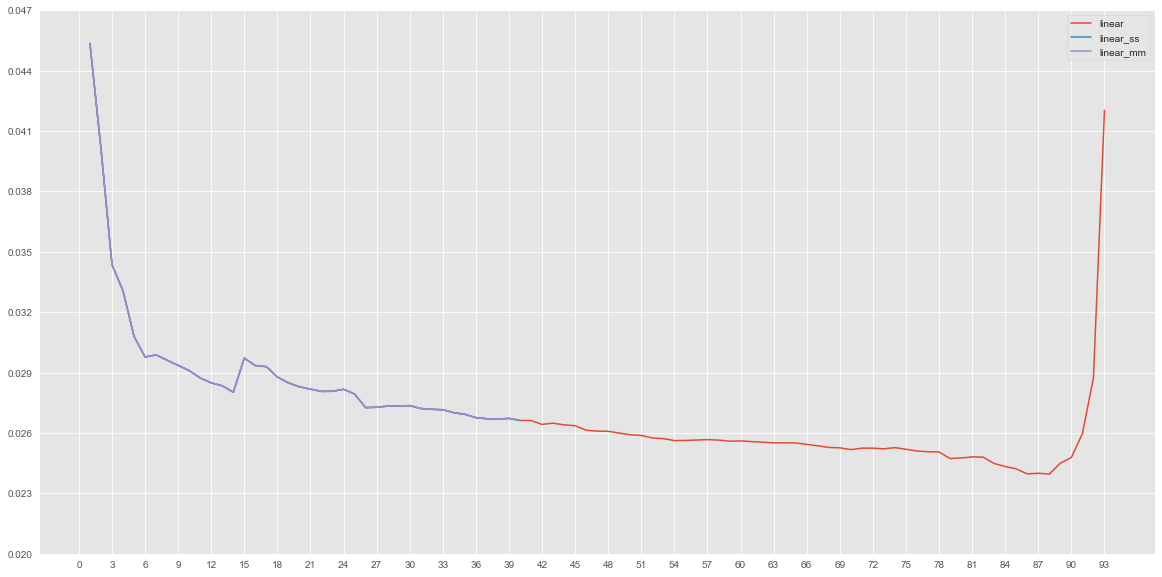

In [8]:
sns.set_palette("tab10")
sns.set_style('darkgrid')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(range(1, 94), linear.loc[(linear.model == 'linear') & \
                                 (linear.scaler == 'none'), 'mean_mse_test'], label = 'linear')
ax.plot(range(1, 41), linear.loc[(linear.model == 'linear') & \
                                 (linear.scaler == 'ss'), 'mean_mse_test'].iloc[:40], label = 'linear_ss')
ax.plot(range(1, 41), linear.loc[(linear.model == 'linear') & \
                                 (linear.scaler == 'mm'), 'mean_mse_test'].iloc[:40], label = 'linear_mm')
ax.legend()
plt.xticks(np.arange(0, 94, 3))
plt.yticks(np.arange(0.02, 0.048, 0.003))
plt.show()

Посмотрим на среднее **MSE** на тестовых фолдах для всех линейных регрессий. Минимальные значения метрик на уровне ~0.024 достигаются при использовании порядка 85-90 регрессоров, включение большего числа, судя по всему, ведет к переобучению. 

В маркировке линий: 
* **mm** для регрессий с масштабированием при помощи MinMaxScaler
* **ss** - с помощью StandardScaler
* **цифры** - доля l1-регуляризации у ElasticNet.

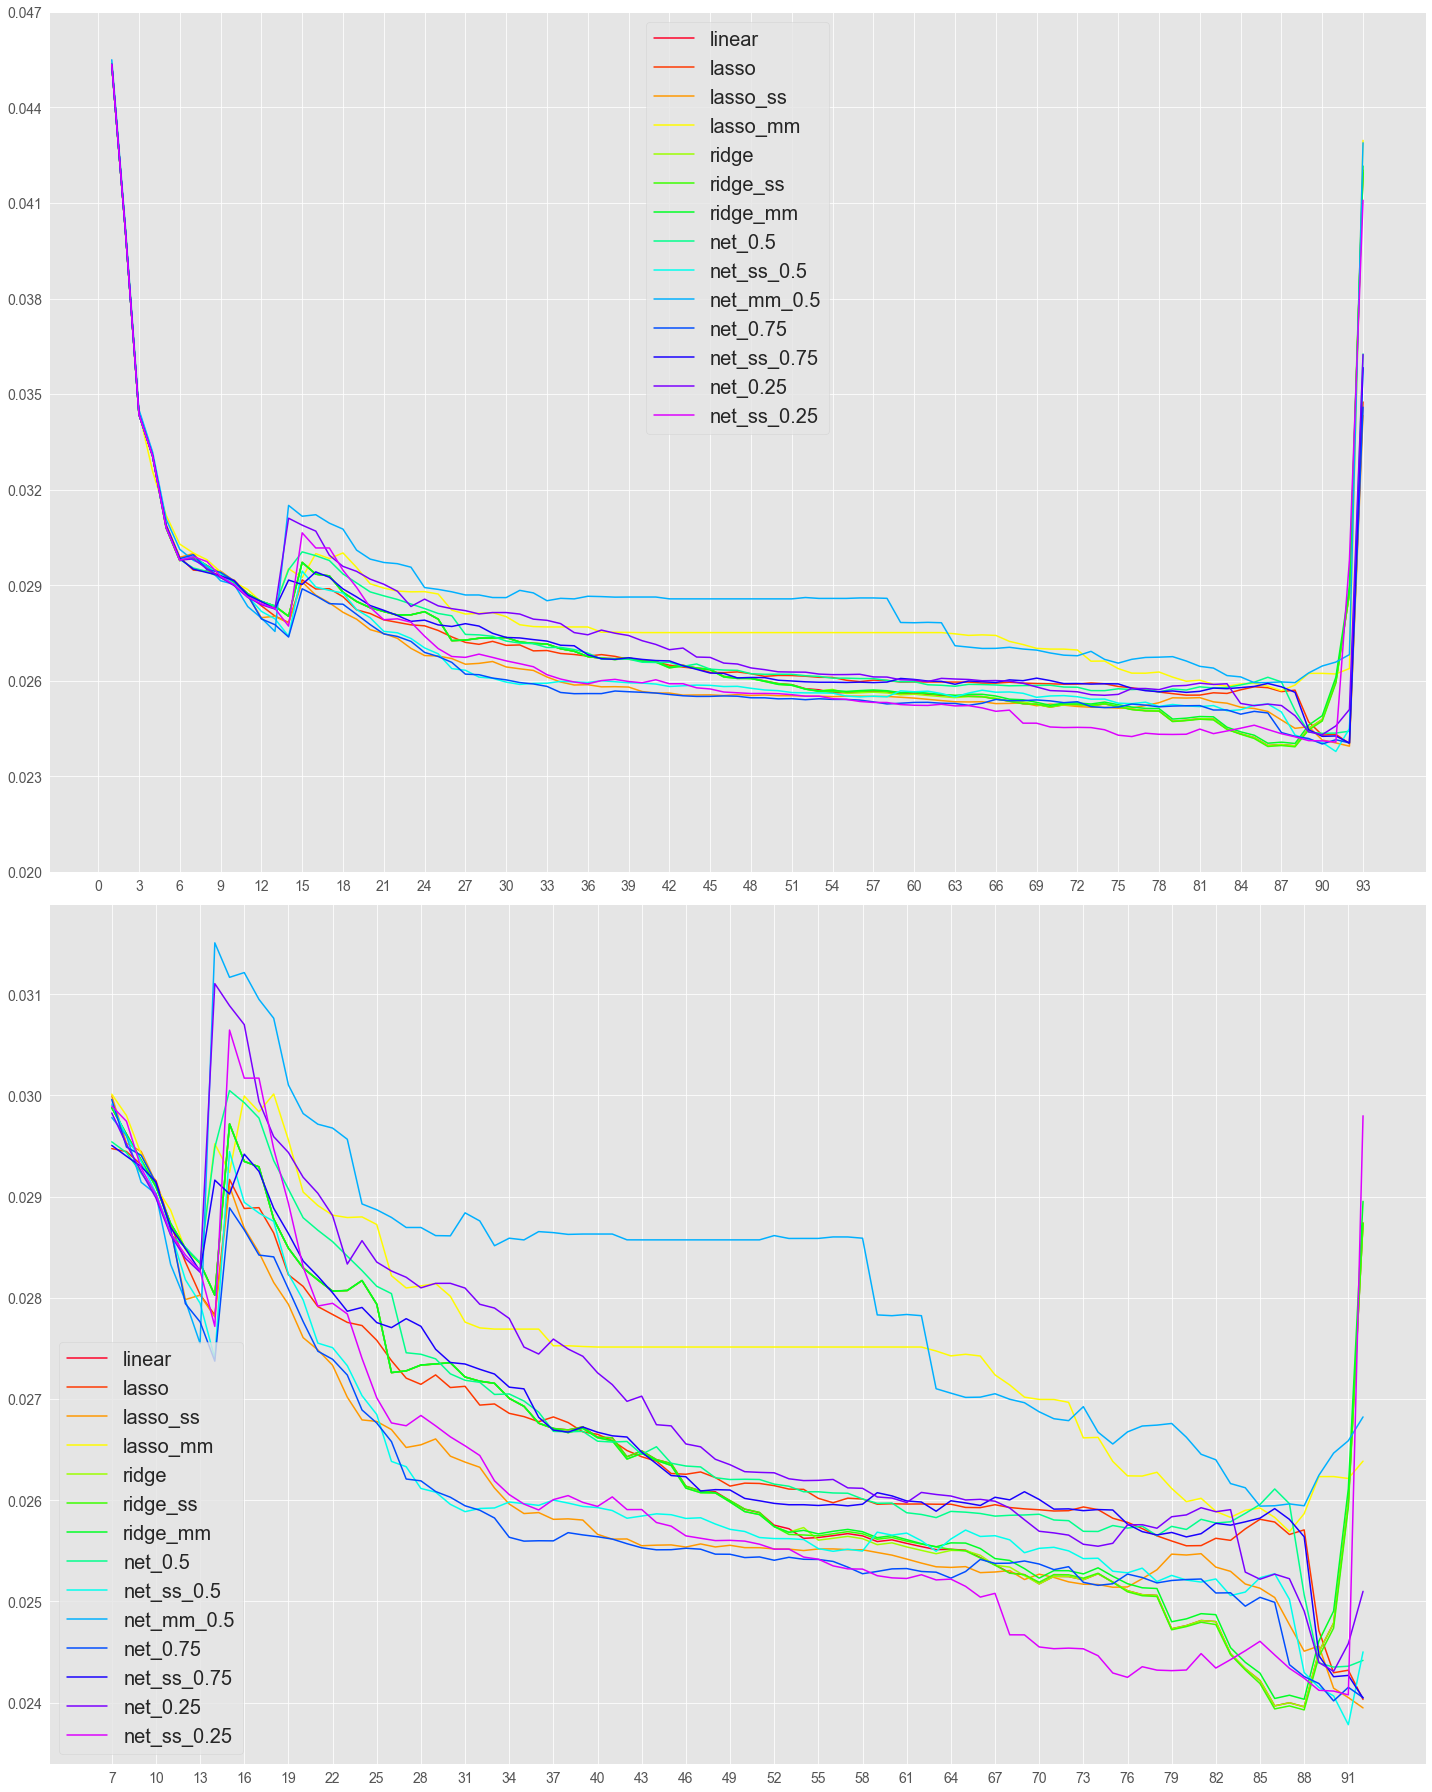

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (20, 25))

cm = plt.get_cmap('gist_rainbow')

ax[0].set_prop_cycle('color', [cm(1.*i/14) for i in range(14)])
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'linear') & \
                                 (linear.scaler == 'none'), 'mean_mse_test'], label = 'linear')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'none'), 'mean_mse_test'], label = 'lasso')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'ss'), 'mean_mse_test'], label = 'lasso_ss')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'mm'), 'mean_mse_test'], label = 'lasso_mm')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'none'), 'mean_mse_test'], label = 'ridge')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'ss'), 'mean_mse_test'], label = 'ridge_ss')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'mm'), 'mean_mse_test'], label = 'ridge_mm')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.5), 'mean_mse_test'], label = 'net_0.5')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.5), 'mean_mse_test'], label = 'net_ss_0.5')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'mm') & \
                                 (linear.l1 == 0.5), 'mean_mse_test'], label = 'net_mm_0.5')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.75), 'mean_mse_test'], label = 'net_0.75')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.75), 'mean_mse_test'], label = 'net_ss_0.75')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.25), 'mean_mse_test'], label = 'net_0.25')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.25), 'mean_mse_test'], label = 'net_ss_0.25')
ax[0].legend(fontsize = 20)
ax[0].set_xticks(np.arange(0, 94, 3))
ax[0].set_yticks(np.arange(0.02, 0.048, 0.003))
ax[0].tick_params(axis = "both", labelsize=14)

ax[1].set_prop_cycle('color', [cm(1.*i/14) for i in range(14)])
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'linear') & \
                                 (linear.scaler == 'none'), 'mean_mse_test'].iloc[6:92], label = 'linear')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'none'), 'mean_mse_test'].iloc[6:92], label = 'lasso')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'ss'), 'mean_mse_test'].iloc[6:92], label = 'lasso_ss')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'mm'), 'mean_mse_test'].iloc[6:92], label = 'lasso_mm')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'none'), 'mean_mse_test'].iloc[6:92], label = 'ridge')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'ss'), 'mean_mse_test'].iloc[6:92], label = 'ridge_ss')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'mm'), 'mean_mse_test'].iloc[6:92], label = 'ridge_mm')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.5), 'mean_mse_test'].iloc[6:92], label = 'net_0.5')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.5), 'mean_mse_test'].iloc[6:92], label = 'net_ss_0.5')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'mm') & \
                                 (linear.l1 == 0.5), 'mean_mse_test'].iloc[6:92], label = 'net_mm_0.5')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.75), 'mean_mse_test'].iloc[6:92], label = 'net_0.75')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.75), 'mean_mse_test'].iloc[6:92], label = 'net_ss_0.75')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.25), 'mean_mse_test'].iloc[6:92], label = 'net_0.25')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.25), 'mean_mse_test'].iloc[6:92], label = 'net_ss_0.25')
ax[1].legend(fontsize = 20)
ax[1].set_xticks(np.arange(7, 93, 3))
ax[1].set_yticks(np.arange(0.024, 0.032, 0.001))
ax[1].tick_params(axis = "both", labelsize=14)

plt.tight_layout()
plt.show()

Теперь посмотрим на **R2_adj**. Примечательно, что скорректированный коэффициент детерминации, в отличие от **MSE**, после определенного порога начинает снижаться с ростом числа регрессоров, что может быть связано с небольшим объемом тестовых выборок (300 наблюдений в одном тестовом фолде).

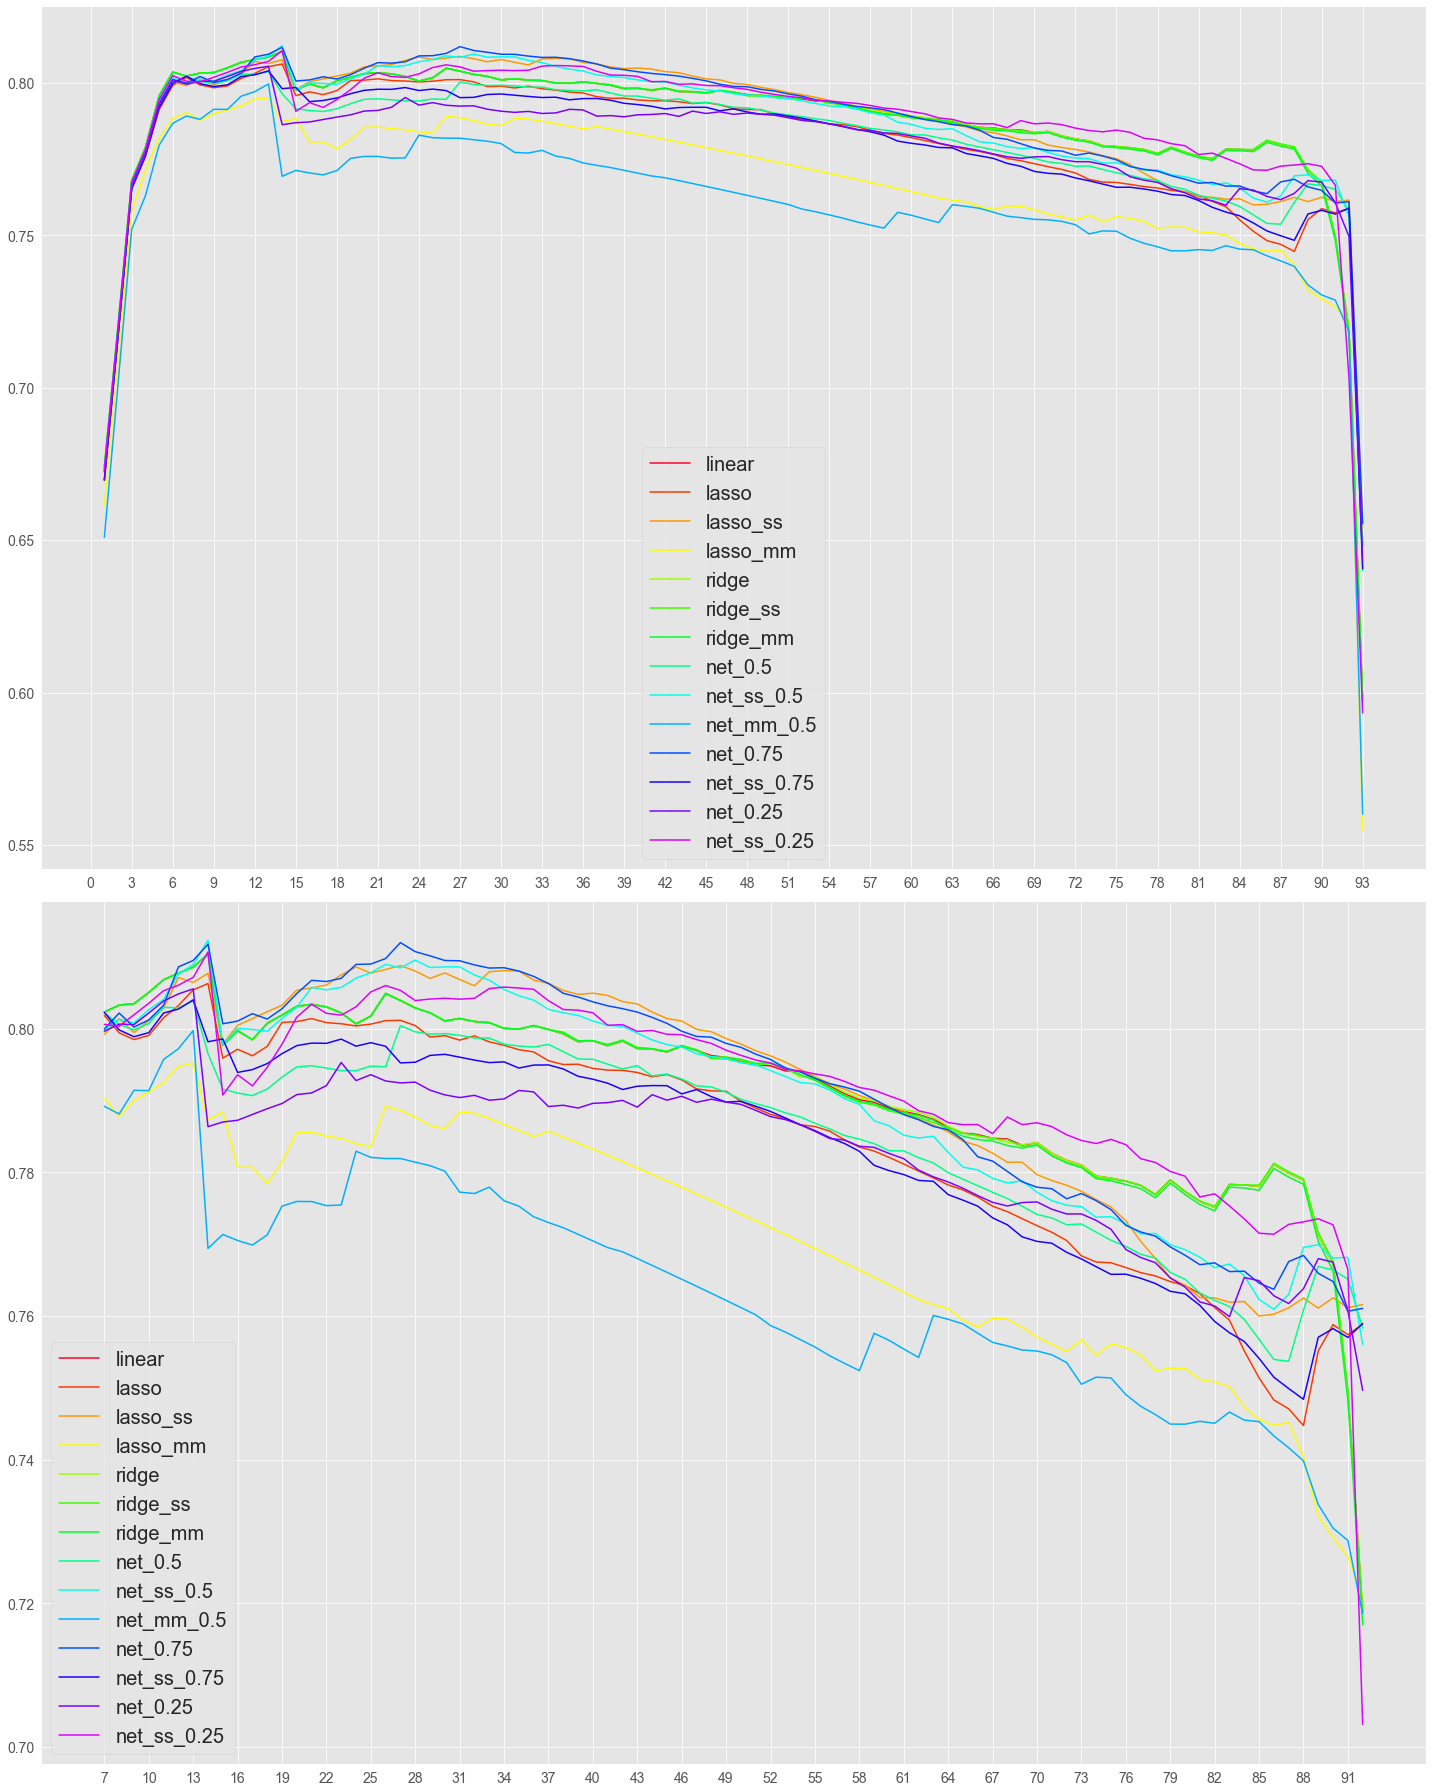

In [10]:
fig, ax = plt.subplots(2, 1, figsize = (20, 25))

cm = plt.get_cmap('gist_rainbow')

ax[0].set_prop_cycle('color', [cm(1.*i/14) for i in range(14)])
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'linear') & \
                                 (linear.scaler == 'none'), 'mean_r2_test'], label = 'linear')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'none'), 'mean_r2_test'], label = 'lasso')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'ss'), 'mean_r2_test'], label = 'lasso_ss')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'mm'), 'mean_r2_test'], label = 'lasso_mm')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'none'), 'mean_r2_test'], label = 'ridge')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'ss'), 'mean_r2_test'], label = 'ridge_ss')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'mm'), 'mean_r2_test'], label = 'ridge_mm')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.5), 'mean_r2_test'], label = 'net_0.5')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.5), 'mean_r2_test'], label = 'net_ss_0.5')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'mm') & \
                                 (linear.l1 == 0.5), 'mean_r2_test'], label = 'net_mm_0.5')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.75), 'mean_r2_test'], label = 'net_0.75')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.75), 'mean_r2_test'], label = 'net_ss_0.75')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.25), 'mean_r2_test'], label = 'net_0.25')
ax[0].plot(range(1, 94), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.25), 'mean_r2_test'], label = 'net_ss_0.25')
ax[0].legend(fontsize = 20)
ax[0].set_xticks(np.arange(0, 94, 3))
ax[0].tick_params(axis = "both", labelsize=14)

ax[1].set_prop_cycle('color', [cm(1.*i/14) for i in range(14)])
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'linear') & \
                                 (linear.scaler == 'none'), 'mean_r2_test'].iloc[6:92], label = 'linear')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'none'), 'mean_r2_test'].iloc[6:92], label = 'lasso')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'ss'), 'mean_r2_test'].iloc[6:92], label = 'lasso_ss')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'lasso') & \
                                    (linear.scaler == 'mm'), 'mean_r2_test'].iloc[6:92], label = 'lasso_mm')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'none'), 'mean_r2_test'].iloc[6:92], label = 'ridge')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'ss'), 'mean_r2_test'].iloc[6:92], label = 'ridge_ss')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'ridge') & \
                                    (linear.scaler == 'mm'), 'mean_r2_test'].iloc[6:92], label = 'ridge_mm')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.5), 'mean_r2_test'].iloc[6:92], label = 'net_0.5')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.5), 'mean_r2_test'].iloc[6:92], label = 'net_ss_0.5')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'mm') & \
                                 (linear.l1 == 0.5), 'mean_r2_test'].iloc[6:92], label = 'net_mm_0.5')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.75), 'mean_r2_test'].iloc[6:92], label = 'net_0.75')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.75), 'mean_r2_test'].iloc[6:92], label = 'net_ss_0.75')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'none') & \
                                 (linear.l1 == 0.25), 'mean_r2_test'].iloc[6:92], label = 'net_0.25')
ax[1].plot(range(7, 93), linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & \
                                 (linear.l1 == 0.25), 'mean_r2_test'].iloc[6:92], label = 'net_ss_0.25')
ax[1].legend(fontsize = 20)
ax[1].set_xticks(np.arange(7, 93, 3))
ax[1].tick_params(axis = "both", labelsize=14)

plt.tight_layout()
plt.show()

Посмотрим на 5 лучших результатов по **MSE**. На первом месте *ElasticNet* с отмасштабированными при помощи *StandardScaler* признаками и *l1-мерой*, равной 0.5. Следом за ней две отмасштабированные *Ridge* и одна *Lasso*, а также одна *Ridge* без масштабирования признаков. Разница между первой и остальными в четвертом знаке после запятой, тогда как для последних четырех разница только в пятом знаке.

In [11]:
linear.loc[linear.mean_mse_test.nsmallest(5).index, 'features':]

features  \
1113  [63 48 65 60 90 49 61 36 85  5  4  8 12 78 77 ...   
552   [63 48 65 60 90 49 61 36 85  5  4  8 74 78 12 ...   
550   [63 48 65 60 90 49 61 36 85  5  4  8 74 78 12 ...   
835   [63 48 65 60 90 49 61 36 85  5  4 66 12  8 74 ...   
366   [63 48 65 60 90 49 61 36 85  5  4  8 74 78 12 ...   

                                         features_names  mean_mse  \
1113  ['total_log', 'sport_points_in_0.01', 'year_me...  0.021459   
552   ['total_log', 'sport_points_in_0.01', 'year_me...  0.021435   
550   ['total_log', 'sport_points_in_0.01', 'year_me...  0.021701   
835   ['total_log', 'sport_points_in_0.01', 'year_me...  0.021760   
366   ['total_log', 'sport_points_in_0.01', 'year_me...  0.021435   

      mean_mse_test   mean_r2  mean_r2_test   std_mse  std_mse_test    std_r2  \
1113       0.023782  0.863359      0.768163  0.000491      0.004947  0.003357   
552        0.023929  0.865507      0.779094  0.000451      0.004790  0.003055   
550        0.023939  0.863745      0.781265  0.000605      0.004628  0.003511   
835        0.023949  0.860105      0.761582  0.000463      0.004602  0.003183   
366        0.023959  0.865505      0.778890  0.000451      0.004799  0.003055   

      std_r2_test  model scaler   l1  
1113     0.052516    net     ss  0.5  
552      0.047819  ridge     ss  NaN  
550      0.048145  ridge     ss  NaN  
835      0.047380  lasso     ss  NaN  
366      0.047995  ridge   none  NaN

Нарисуем зависимость средней **MSE** на тестовых выборках от количества выбранных регрессоров с интервалом +- стандартная ошибка метрики для лучшей модели.

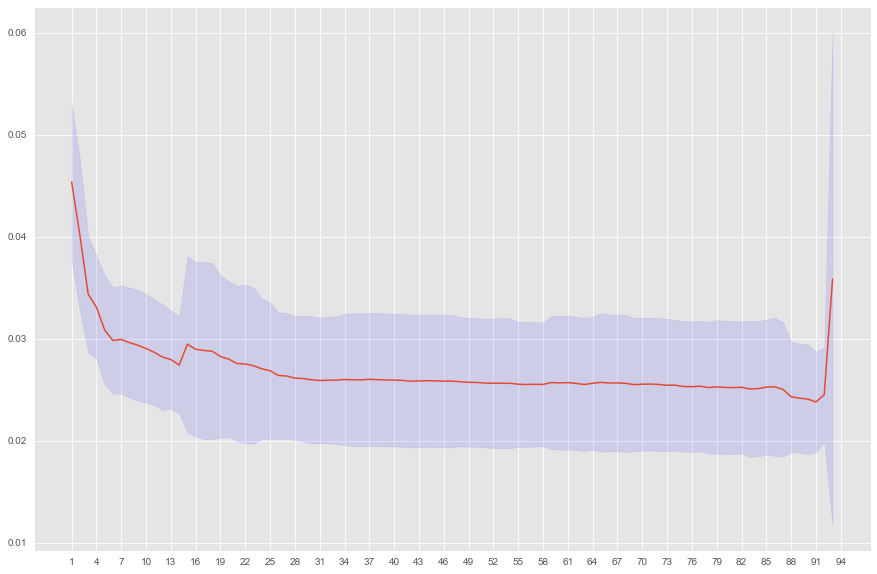

In [12]:
a = linear.loc[(linear.model == 'net') & (linear.scaler == 'ss') & (linear.l1 == 0.5), :]
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(range(1, 94), a.mean_mse_test)
ax.fill_between(range(1, 94), \
                   (a.mean_mse_test - a.std_mse_test), \
                   (a.mean_mse_test + a.std_mse_test), color = 'b', alpha = 0.1)
ax.set_xticks(np.arange(1, 95, 3))
plt.show()

Обучим лучшую линейную модель на всем датасете.

In [13]:
best_linear = linear_model(max_features = 91, model = 'elastic_net', iters = 5000, scaler = 'standard', cv = False)

0
1
2
3
4
5
6
7
8
9


Посмотрим на полученные оценки коэффициентов, за исключением оценок, равных нулю. Основные переменные, положительно влияющие на стоимость квартиры:
* Общая площадь
* Год постройки дома (с учетом включения двух переменных: там, где пропуски заполнены медианой и там, где наиболее частым значением)
* Наличие дизайнерского/косметического/евро ремонта (альтернатива - без ремонта)
* Железобетонный тип перекрытий в доме (здесь альтернатива - деревянные перекрытия)
* Количество спортивных объектов, магазинов и автобусных остановок в радиусе километра, объектов досуга в радиусе 500 метров
* Число лоджий и число балконов
* Высотность здания
* Остается ли в квартире мебель
* Двух и трех-комнатность квартир по сравнению с однушками

Отрицательно влияющие на стоимость:
* Количество зданий и объектов туризма в радиусе 500 метров
* Расстояние до ближайшей автобусной остановки
* Количество безопасных пересечений проезжей части в радиусе 100 метров

const: 14.8866


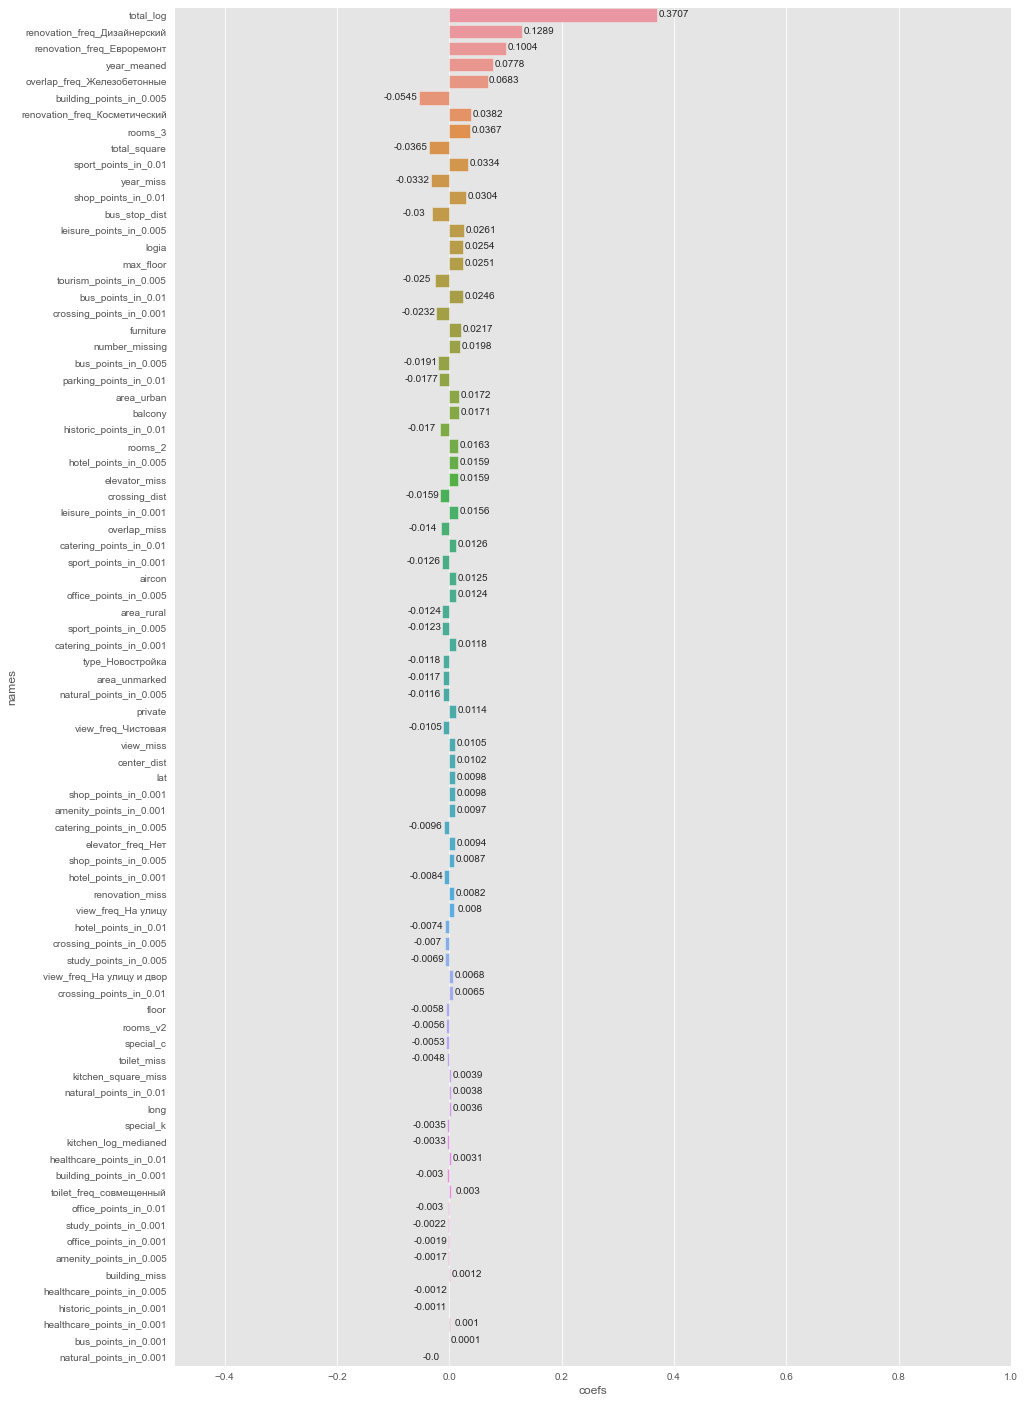

In [14]:
a = pd.DataFrame({'names' : best_linear.names, 'coefs' : best_linear.coefs, 'abs' : np.abs(best_linear.coefs)}) \
.sort_values('abs', ascending = False)

print('const:', round(best_linear.intercept, 4))
fig, ax = plt.subplots(figsize = (15,25))
ax = sns.barplot(x = a.loc[a.coefs != 0, 'coefs'], y = a.loc[a.coefs != 0, 'names'], orient='h');
for p in ax.patches:
    if p.get_width() > 0:
        _x = p.get_x() + p.get_width() + 0.03
    else:
        _x = p.get_x() + p.get_width() + -0.032
    _y = p.get_y() + p.get_height() - 0.3
    value = round(p.get_width(), 4)
    ax.text(_x, _y, value, ha = "center")
ax.set_xlim(left = -0.49, right = 1)

plt.show()

Попробуем проинтерпретировать коэффициенты полученной регрессии (не забывая про масштабирование признаков).

In [15]:
dd = processing(scaler = 'standard', cv = False, scaling_return=True)
dd = dd[dd.names.isin(['total_log', 'total_square', 'year_meaned', 'year_freq', 'floor', 'max_floor', \
                       'sport_points_in_0.01', 'shop_points_in_0.01', 'bus_points_in_0.01', 'leisure_points_in_0.005', \
                       'logia', 'balcony', 'max_floor', 'building_points_in_0.005', 'tourism_points_in_0.005', \
                       'crossing_points_in_0.001'])]
dd = pd.merge(dd, a, on = 'names', how = 'left').sort_values('abs', ascending = False)

print('При неизменности остальных регрессоров:')
for name in dd.names:
    if not ('total' in name) | ('year' in name):
        b = round(dd.loc[dd.names == name, 'coefs'].values[0] / \
                  dd.loc[dd.names == name, 'scale'].values[0]*100, 3)
        print('Увеличение', '\033[1m' + f'{name}' + '\033[0m', 'на единицу приводит к изменению цены на', \
              '\033[1m' + f'{b}' + '\033[0m', '%')
    elif ('year_meaned' in name):
        b = round((dd.loc[dd.names == 'year_meaned', 'coefs'].values[0] + \
             dd.loc[dd.names == 'year_freq', 'coefs'].values[0])/20*100, 3)
        print('Увеличение', '\033[1m' + 'year' + '\033[0m', 'на единицу приводит к изменению цены на', \
              '\033[1m' + f'{b}' + '\033[0m', '%')

При неизменности остальных регрессоров:
Увеличение year на единицу приводит к изменению цены на 0.389 %
Увеличение building_points_in_0.005 на единицу приводит к изменению цены на -0.033 %
Увеличение sport_points_in_0.01 на единицу приводит к изменению цены на 0.272 %
Увеличение shop_points_in_0.01 на единицу приводит к изменению цены на 0.218 %
Увеличение leisure_points_in_0.005 на единицу приводит к изменению цены на 0.121 %
Увеличение logia на единицу приводит к изменению цены на 5.339 %
Увеличение max_floor на единицу приводит к изменению цены на 0.818 %
Увеличение tourism_points_in_0.005 на единицу приводит к изменению цены на -1.11 %
Увеличение bus_points_in_0.01 на единицу приводит к изменению цены на 0.607 %
Увеличение crossing_points_in_0.001 на единицу приводит к изменению цены на -0.869 %
Увеличение balcony на единицу приводит к изменению цены на 3.116 %
Увеличение floor на единицу приводит к изменению цены на -0.203 %


С интерпретацией влияния площади на стоимость появляются некоторые сложности, поскольку площадь одновременно входит в регрессию и в уровнях, и в логарифмах, а исключение одной из этих переменных ухудшает качество получаемых результатов. Исходя из производной, если регрессия выглядит следующим образом (где y - стоимость квартиры, x - общая площадь):

$ \ln{\hat{y}} = \hat{\alpha}*x + \hat{\beta}*ln{x} $

Тогда зависимость изменения объясняемой переменной от изменений объясняющих переменных:

$ \frac{\Delta{\hat{y}}}{\hat{y}}\ = (\hat{\alpha} + \frac{\hat{\beta}}{x})*\Delta{x}$ 

Что означает процентное изменение y на $100*\alpha$ при изменении x на 1 единицу и одновременное изменение y на $\beta$ % при изменении x на 1 %. 

Но я не уверен, что такая интерпретация оценок коэффициентов правильная, так что просто покажу, как графически выглядит оцененная функциональная форма зависимости стоимости квартиры от ее общей площади (на значения по оси Y не нужно обращать внимание, они не скорректированы).

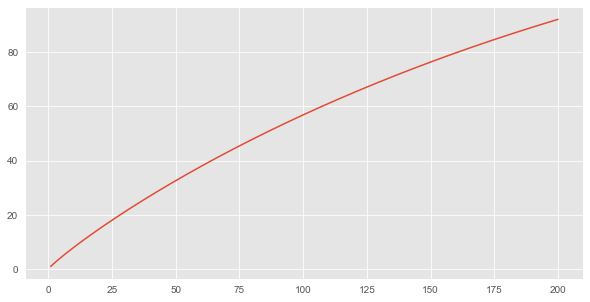

In [16]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(np.arange(1, 200, 0.01), np.exp(dd.loc[dd.names == 'total_square', 'coefs'].values[0] * \
                                        (np.arange(1, 200, 0.01)) / \
                                        dd.loc[dd.names == 'total_square', 'scale'].values[0] + \
                                        dd.loc[dd.names == 'total_log', 'coefs'].values[0] * \
                                        (np.log(np.arange(1, 200, 0.01))) / \
                                        dd.loc[dd.names == 'total_log', 'scale'].values[0]));

Таким образом, среди линейных регрессий лучшей оказалась **ElasticNet**:
* С **91** регрессорами, из которых **45** по результатам оценивания имеют ненулевые оценки соответствующих им коэффициентов
* Масштабированием числовых переменных при помощи **StandardScaler**
* l1-мерой, равной **0.5** 
* Коэффициентом регуляризации alpha, равным **0.001**
* Средним  значением среднеквадратической ошибки по результатам кросс-валидации на трейне **0.021459**, на тесте **0.023782**
* Средним  значением скорректированного коэффициента детерминации по результатам кросс-валидации на трейне **0.863359**, на тесте **0.768163**

Стоит заметить, что до появления географических признаков минимальное MSE на тестовой выборке было выше 0.04, так что с ними результат определенно становится лучше.

### Случайный лес

In [17]:
starter = starter.reset_index()

Результаты 5 лучших моделей выведены ниже. Каждый из представленных результатов получен на втором шаге отбора переменных.

In [18]:
starter.loc[starter.mean_mse_test.nsmallest(5).index, :]

index      mse0  mse_test0      mse1  mse_test1      mse2  mse_test2  \
1         1  0.002627   0.018727  0.002545   0.027897  0.002709   0.015129   
2687      1  0.008271   0.017659  0.008082   0.028893  0.008321   0.016242   
881       1  0.009568   0.019052  0.009357   0.029105  0.010050   0.015294   
2896      1  0.010731   0.019336  0.009911   0.029670  0.010904   0.015412   
431       1  0.010939   0.019530  0.010266   0.028789  0.011118   0.015459   

          mse3  mse_test3      mse4  ...  bootstrap  mean_mse  mean_mse_test  \
1     0.002539   0.018208  0.002693  ...       True  0.002637       0.018388   
2687  0.008208   0.018820  0.008452  ...       True  0.008255       0.018767   
881   0.009509   0.019766  0.009953  ...       True  0.009708       0.019438   
2896  0.010369   0.019782  0.010813  ...       True  0.010580       0.019646   
431   0.010740   0.019753  0.011149  ...       True  0.010870       0.019685   

       mean_r2  mean_r2_test   std_mse  std_mse_test    std_r2  std_r2_test  \
1     0.984710      0.867643  0.000080      0.003927  0.000525     0.023663   
2687  0.950486      0.878376  0.000123      0.004040  0.000990     0.022582   
881   0.939944      0.856187  0.000212      0.003866  0.001532     0.022890   
2896  0.934685      0.857102  0.000284      0.004064  0.001835     0.024129   
431   0.932578      0.855932  0.000253      0.003795  0.001683     0.023414   

      treshold  
1        0.001  
2687     0.005  
881      0.001  
2896     0.001  
431      0.001  

[5 rows x 67 columns]

Здесь не получилось как-либо улучшить результаты с помощью перебора параметров, минимальная среднеквадратическая ошибка наблюдается у самой первой модели со всеми начальными гиперпараметрами и порогом значимости, равным 0.001, что может быть связано как с тем, что оценивания 1000 комбинаций этих гиперпараметров оказалось недостаточно, так и с тем, что было не совсем верно определено их пространство. И, возможно, задав для некоторых из них другие границы, можно было бы получить результаты получше. 

Может быть, дело также в том, что признаки отбираются на основании значений важностей, полученных по обычному критерию *Gini impurity*, что может приводить к неверным результатам при мультиколлинеарности, однако второй шаг отбора, судя по результатам, как правило всегда лучше первого.

В любом случае слишком углубляться в улучшение результатов здесь не очень хочется, так как все то, что делает случайный лес, может обычно лучше делать градиентный бустинг, и хочется побольше поработать с ним. Оценки, полученные на данном этапе, будем использовать как промежуточный результат между линейныйми регрессиями и бустингами в качестве показателя того, что модели посложнее выигрывают в рассматриваемой задаче не только у относительно несложных линейных регрессий, но хотя бы и у случайного леса.

Обучим лучший лес на всем датасете.

In [19]:
best_forest = forest_model(threshold = 0.001, cv = False)

0
1


Согласно полученным важностям, наибольшей вес в модели имеет общая площадь, однако и остальные переменные, несмотря на небольшие значения важности, также вносят свой вклад в модель, поскольку при повышении порога, по которому отбираются переменные, и соответствующего удаления части признаков из модели, снижается качество как на тренировочной, так и на тестовых выборках.

Примечательно также, что после очевидно существенных для модели признаков (площади, этажности и года постройки) высокие важности здесь имеют долгота и широта. В целом географические признаки проявляют свой вклад и для для случайного леса - без них среднеквадртатическая ошибка была не меньше 0.23.

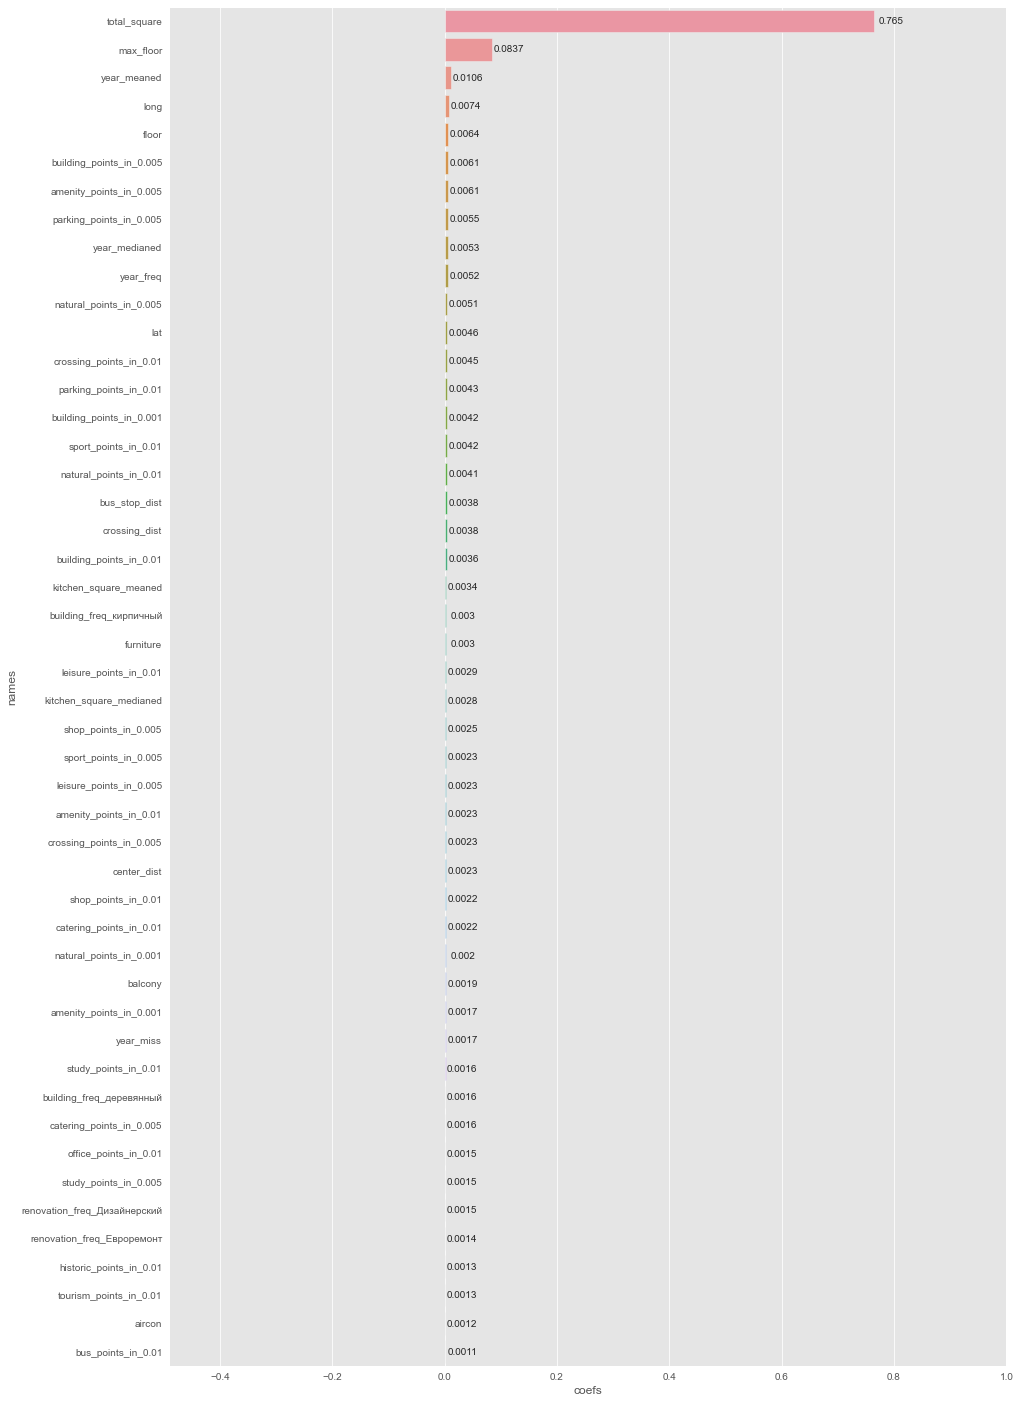

In [20]:
a = pd.DataFrame({'names' : best_forest.features, 'coefs' : best_forest.importance}) \
.sort_values('coefs', ascending = False)

fig, ax = plt.subplots(figsize = (15,25))
ax = sns.barplot(x = a.loc[a.coefs != 0, 'coefs'], y = a.loc[a.coefs != 0, 'names'], orient='h');
for p in ax.patches:
    if p.get_width() > 0:
        _x = p.get_x() + p.get_width() + 0.03
    else:
        _x = p.get_x() + p.get_width() + -0.032
    _y = p.get_y() + p.get_height() - 0.3
    value = round(p.get_width(), 4)
    ax.text(_x, _y, value, ha = "center")
ax.set_xlim(left = -0.49, right = 1)

plt.show()

### Градиентный бустинг

In [21]:
starter_bstr = starter_bstr.reset_index()

Снова смотрим на 5 результатов с наименьшей среднеквадратической ошибкой.

In [22]:
starter_bstr.loc[starter_bstr.mean_mse_test.nsmallest(5).index]

index      mse0  mse_test0      mse1  mse_test1      mse2  mse_test2  \
1002      2  0.006762   0.017286  0.007162   0.025397  0.009263   0.013845   
1         1  0.008885   0.017273  0.006380   0.026502  0.009093   0.013850   
1160      1  0.005759   0.016847  0.006587   0.025169  0.005125   0.014296   
421       0  0.006702   0.017597  0.006688   0.024084  0.007445   0.013611   
314       2  0.009610   0.017099  0.008324   0.026027  0.007633   0.013831   

          mse3  mse_test3      mse4  ...    grow_policy  mean_mse  \
1002  0.007384   0.016597  0.007908  ...  SymmetricTree  0.007717   
1     0.008809   0.017355  0.010127  ...  SymmetricTree  0.007585   
1160  0.005170   0.016925  0.005169  ...      Depthwise  0.004904   
421   0.007741   0.018213  0.005582  ...      Depthwise  0.005672   
314   0.008285   0.017029  0.009145  ...  SymmetricTree  0.007821   

      mean_mse_test   mean_r2  mean_r2_test   std_mse  std_mse_test    std_r2  \
1002       0.016322  0.954939      0.886310  0.000817      0.004272  0.004915   
1          0.016396  0.955051      0.872398  0.001682      0.004308  0.010432   
1160       0.016462  0.971926      0.892173  0.001157      0.003860  0.007197   
421        0.016465  0.966567      0.857189  0.001461      0.003750  0.008816   
314        0.016510  0.954472      0.889251  0.000997      0.004347  0.006547   

      std_r2_test  treshold  
1002     0.025316    0.0005  
1        0.027386    0.0001  
1160     0.022654    0.0010  
421      0.030177    0.0005  
314      0.023844    0.0005  

[5 rows x 70 columns]

Лучший скор показывает одна из моделей, найденная в процессе перебора гиперпараметров, на третьем шаге отбора важных признаков с:
* Минимальным порогом важности **0.0005**
* Максимальным числом деревьев, равным **1500** (на самом деле построение деревьев заканчивается на **337** шаге)
* Глубиной деревьев **6**
* Немного более сильной регуляризацией (**5** по сравнению с начальными **3**)
* **Симметричным** построением деревьев

Визаулизируем важности признаков, полученные с помощью *permutation_importance*.

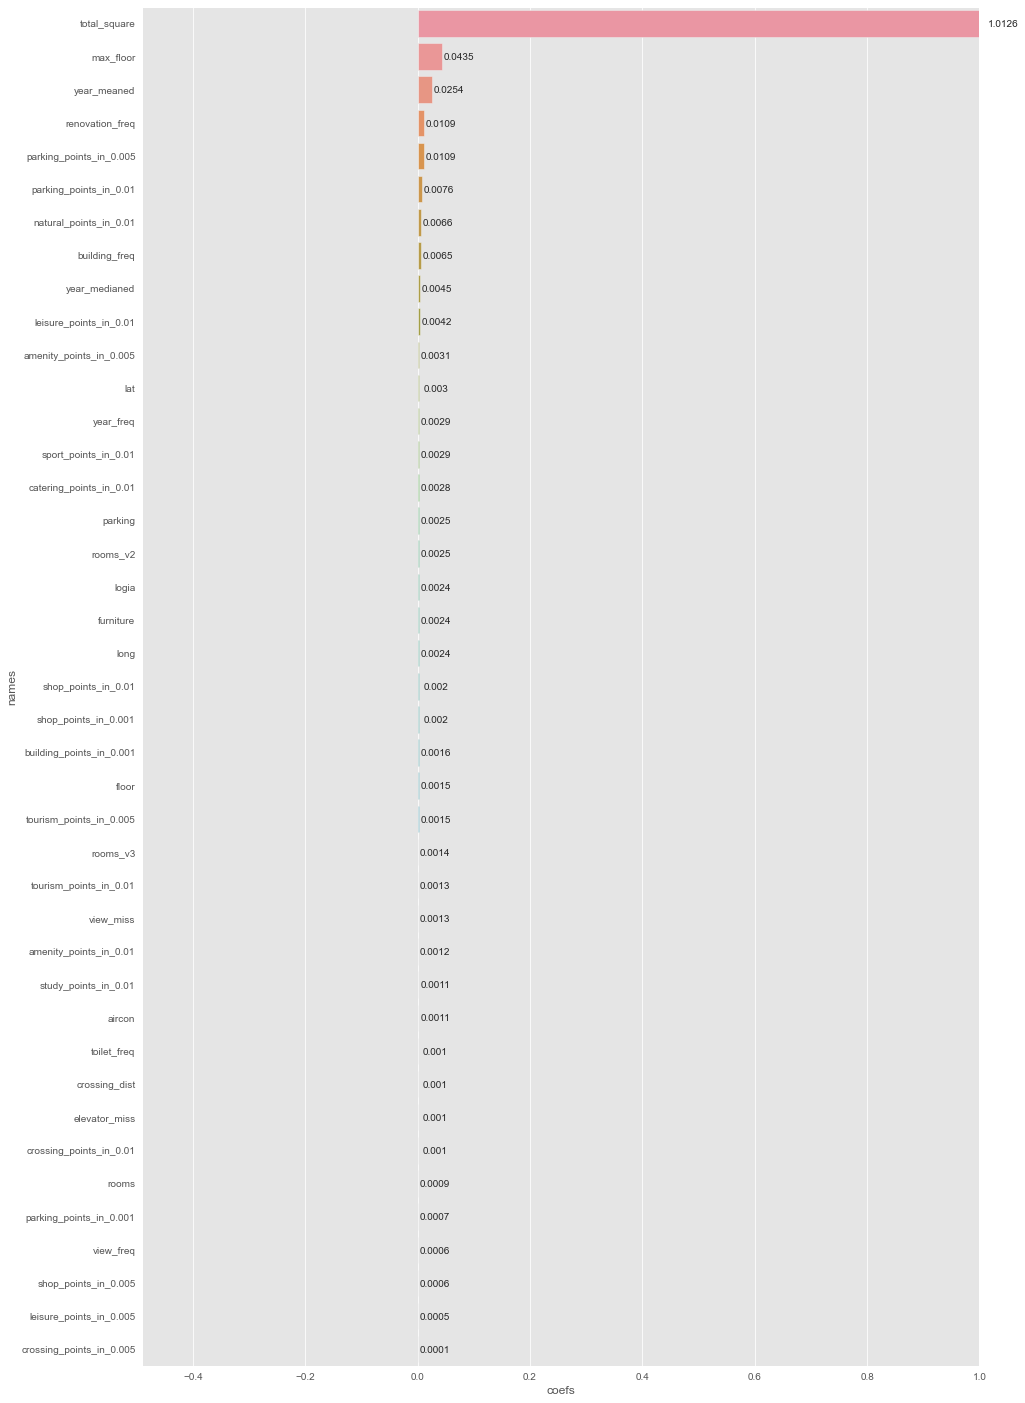

In [23]:
a = pd.DataFrame({'names' : starter_bstr.loc[1002, 'features'], \
                  'coefs' : list(map(float, starter_bstr.loc[1002, 'feat_imps_mean']))}) \
.sort_values('coefs', ascending = False)

fig, ax = plt.subplots(figsize = (15,25))
ax = sns.barplot(x = a.loc[a.coefs != 0, 'coefs'], y = a.loc[a.coefs != 0, 'names'], orient='h');
for p in ax.patches:
    if p.get_width() > 0:
        _x = p.get_x() + p.get_width() + 0.03
    else:
        _x = p.get_x() + p.get_width() + -0.032
    _y = p.get_y() + p.get_height() - 0.3
    value = round(p.get_width(), 4)
    ax.text(_x, _y, value, ha = "center")
ax.set_xlim(left = -0.49, right = 1)

plt.show()

Привожу также важности для второй модели с лучшим скором. Здесь отобралось чуть больше признаков (так как уменьшился порог прохождения с 0.005 до 0.001), но в целом важности практически совпадают.

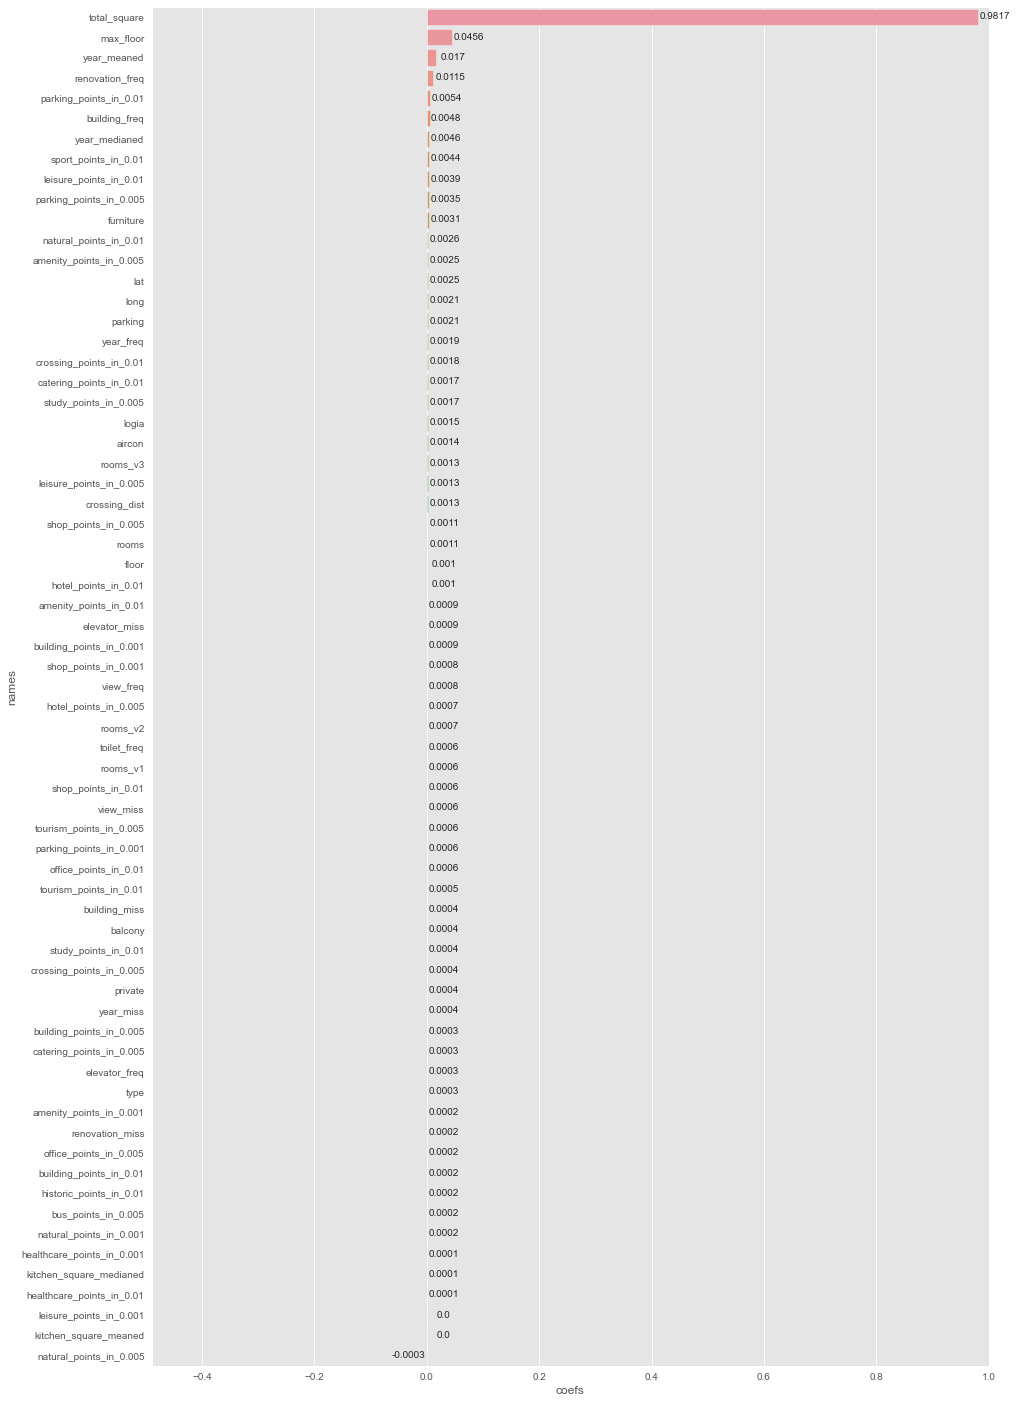

In [24]:
a = pd.DataFrame({'names' : starter_bstr.loc[1, 'features'], \
                  'coefs' : list(map(float, starter_bstr.loc[1, 'feat_imps_mean']))}) \
.sort_values('coefs', ascending = False)

fig, ax = plt.subplots(figsize = (15,25))
ax = sns.barplot(x = a.loc[a.coefs != 0, 'coefs'], y = a.loc[a.coefs != 0, 'names'], orient='h');
for p in ax.patches:
    if p.get_width() > 0:
        _x = p.get_x() + p.get_width() + 0.03
    else:
        _x = p.get_x() + p.get_width() + -0.032
    _y = p.get_y() + p.get_height() - 0.3
    value = round(p.get_width(), 4)
    ax.text(_x, _y, value, ha = "center")
ax.set_xlim(left = -0.49, right = 1)

plt.show()

Попробуем отобрать еще несколько признаков для первого бустинга, туда, например, вошли сразу несколько вариантов представлений комнатности квартиры в числовом виде, а также сразу три переменные, отвечающие за год, где по-разному заполнены пропуски.

Так как эти переменные имеют высокую корреляцию, их важности могли быть рассчитаны не совсем точно, а модель, включающую несколько вариаций одной переменной не очень хочется интерпретировать, проверим, станет ли бустинг лучше, если оставить в нем только по одному экземпляру признаков, описанных выше.

Но тут первоначально лучший бустинг (индекс 1002 в *starter*) начинает давать результаты хуже. Если оставлять только одну из четырех переменных, отвечающих за комнаты/одну из трех, отвечающих за год/одну из двух, отвечающих за площадь кухни, **MSE** сильно снижается на тестовой части (приблизительно до **0.017**). Выглядит так, как будто бустинг переобучился и стал подстраиваться под определенные наблюдения, или выбранных признаков на самом деле не хватает для полного описания стоимости, а лучшая **MSE** для этой модели была получена случайным образом.

Однако скор у второй модели (бустинг с начальными параметрами, индекс 1 в *starter*) улучшается с удалением лишних коррелирующих признаков. Минимальная среднеквадратическая ошибка достигается, если оставить заполнение пропусков года постройки с помощью *среднего*, площади кухни с помощью медианы и использовать четвертый вариант расчета комнатности квартиры, то есть сравнивая площадь каждой отдельно взятой проблемной (*студии* и *квартиры свободной планировки*) квартиры со средними площадями по комнатным квартирам в выборке и находя наиболее похожие. В таком случае **MSE** на тестовой выборке составляет **0.01603**, что соответствует **RMSE**, равной **0.1266** (напомню, что лучший предыдущий результат по **MSE**: **0.016322**).

In [50]:
step = 0
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
aaa = np.array(starter_bstr.loc[1, 'features'])
predictions_best = pd.DataFrame(index = data_train.index, columns = ['preds'])
a = []
for i in range(0, 10): 
    a.append(f'mse{i}')
    a.append(f'mse_test{i}')
for i in range(0, 10):    
    a.append(f'feat_imps{i}')
a.append('feat_imps_mean')
res_n = pd.DataFrame(columns = a)
for index_train, index_test in kf.split(data_train):
    train, test, val = processing(scaler = None, cv = True, index_train = index_train, index_test = index_test)

    X_train = train.drop(['price', 'kitchen_log_meaned', 'total_log', 'kitchen_log_medianed'], axis = 1)
    X_test = test.drop(['price', 'kitchen_log_meaned', 'total_log', 'kitchen_log_medianed',], axis = 1)
    X_val = val.drop(['price', 'kitchen_log_meaned', 'total_log', 'kitchen_log_medianed',], axis = 1)
    X_test[X_val.columns.difference(X_test.columns).append(X_train.columns.difference(X_test.columns))] = 0
    X_train[X_val.columns.difference(X_train.columns).append(X_test.columns.difference(X_train.columns))] = 0
    X_val[X_train.columns.difference(X_val.columns).append(X_test.columns.difference(X_val.columns))] = 0
    X_train = X_train.loc[:, ~X_train.columns.duplicated()]
    X_test = X_test.loc[:, ~X_test.columns.duplicated()]
    X_val = X_val.loc[:, ~X_val.columns.duplicated()]
    y_train = np.log(train.price)
    y_test = np.log(test.price)
    y_val = np.log(val.price)

    feat_use = aaa[(aaa != 'year_freq') & (aaa != 'year_medianed') & (aaa != 'kitchen_square_meaned') & \
                   (aaa != 'rooms') & (aaa != 'rooms_v1') & (aaa != 'rooms_v2')].tolist()
    X_train = X_train.loc[:, feat_use]
    X_test = X_test.loc[:, feat_use]
    X_val = X_val.loc[:, feat_use]

    bstr = ctb.CatBoostRegressor(cat_features = list(X_train.columns[X_train.dtypes == 'O']),
                                 random_state = 42)
    bstr.fit(X_train, y_train, verbose = False)
    prs = bstr.predict(X_test)
    prs_train = bstr.predict(X_train)

    res_n.loc[0, f'mse{step}'] = mean_squared_error(prs_train, y_train)
    res_n.loc[0, f'mse_test{step}'] = mean_squared_error(prs, y_test)
    res_n.at[0, f'feat_imps{step}'] = \
    permutation_importance(bstr, X_val, y_val, n_repeats = 50, random_state = 42).importances_mean
    predictions_best.at[test.index, 'preds'] = prs
    step += 1
res_n.loc[0, 'feat_imps_mean'] = (res_n.loc[0, 'feat_imps0'] + res_n.loc[0, 'feat_imps1'] + \
                                    res_n.loc[0, 'feat_imps2'] + res_n.loc[0, 'feat_imps3'] + \
                                    res_n.loc[0, 'feat_imps4'] + res_n.loc[0, 'feat_imps5'] + \
                                    res_n.loc[0, 'feat_imps6'] + res_n.loc[0, 'feat_imps7'] + \
                                    res_n.loc[0, 'feat_imps8'] + res_n.loc[0, 'feat_imps9'])/10
res_n['mean_mse'] = res_n.apply(lambda x: np.mean([x[f'mse{i}'] for i in range(10)]), axis = 1)
res_n['mean_mse_test'] = res_n.apply(lambda x: np.mean([x[f'mse_test{i}'] for i in range(10)]), axis = 1)
res_n['std_mse'] = res_n.apply(lambda x: np.std([x[f'mse{i}'] for i in range(10)]), axis = 1)
res_n['std_mse_test'] = res_n.apply(lambda x: np.std([x[f'mse_test{i}'] for i in range(10)]), axis = 1)
res_n.iloc[:, np.r_[0:20, 30:35]]

mse0 mse_test0      mse1 mse_test1     mse2 mse_test2      mse3  \
0  0.005262  0.016954  0.005039  0.025588  0.00537  0.013522  0.005339   

  mse_test3     mse4 mse_test4  ... mse_test7      mse8 mse_test8      mse9  \
0  0.017088  0.00539  0.013813  ...  0.013239  0.005456   0.01429  0.005609   

  mse_test9                                     feat_imps_mean  mean_mse  \
0  0.009356  [0.0015795415019702545, 0.036648307018880485, ...  0.005309   

  mean_mse_test   std_mse std_mse_test  
0       0.01603  0.000166     0.004134  

[1 rows x 25 columns]

Снова смотрим на важности использованных признаков (теперь для точности расчета использовались перемешивания по 50 раз вместо 10 в *permutation_importance*. Исключение признаков с отрицательной и околонулевой важностями не приводит к улучшению результата, возможно одного сета с 300 наблюдениями не хватает для точной оценки, а возможно и то, что стоит попробовать интерпретировать полученные результаты иным образом.

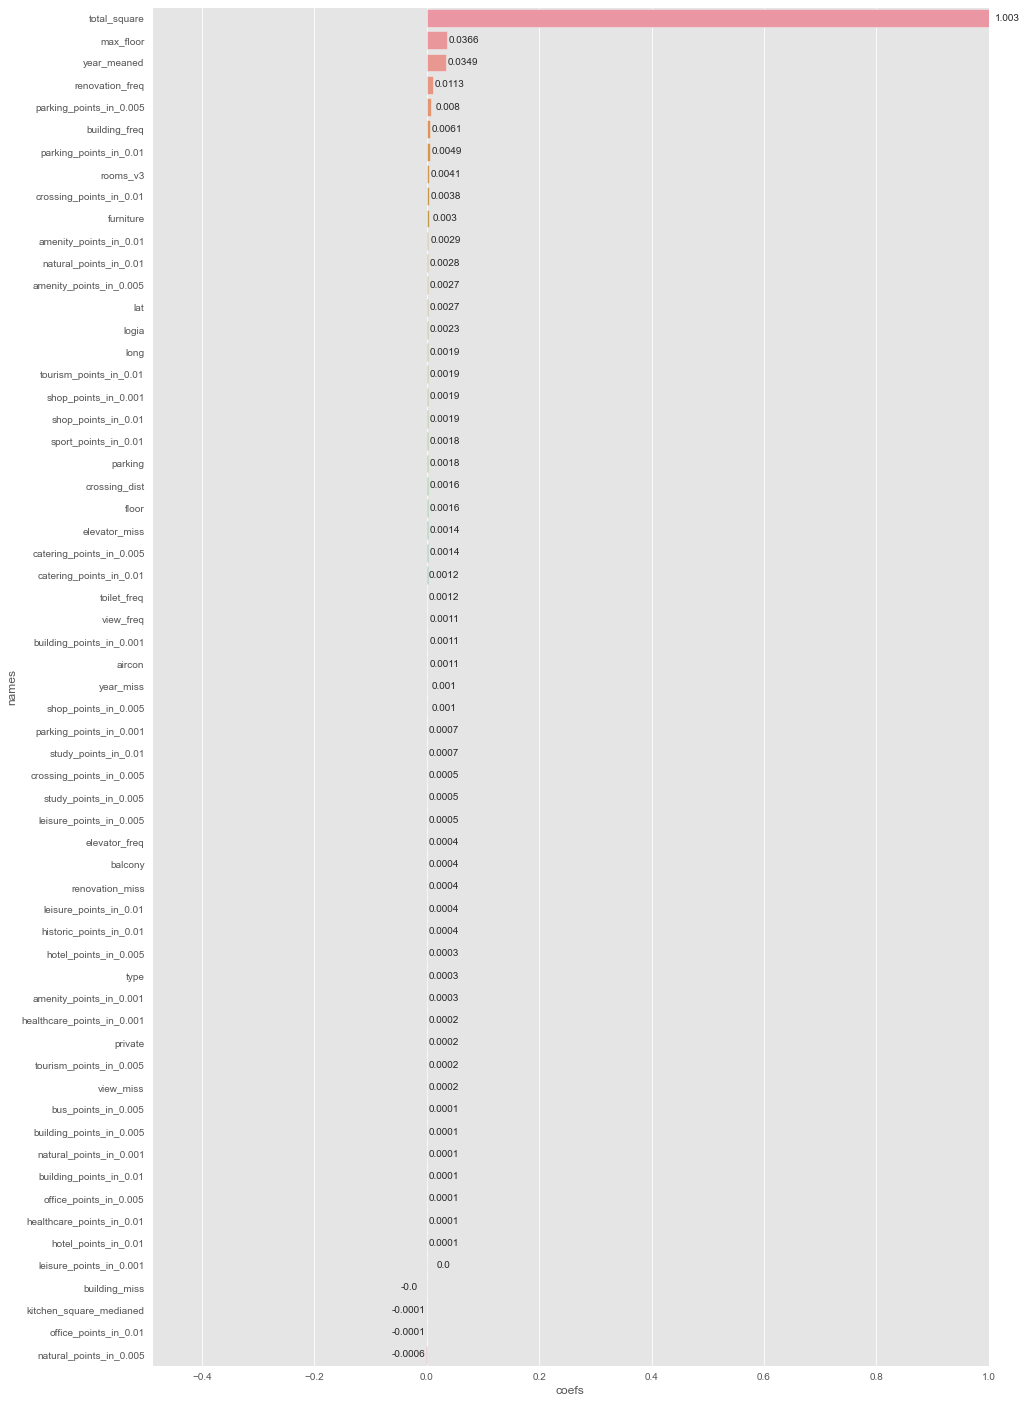

In [26]:
a = pd.DataFrame({'names' : feat_use, \
                  'coefs' : res_n.feat_imps_mean.values[0]}) \
.sort_values('coefs', ascending = False)

fig, ax = plt.subplots(figsize = (15,25))
ax = sns.barplot(x = a.loc[a.coefs != 0, 'coefs'], y = a.loc[a.coefs != 0, 'names'], orient='h');
for p in ax.patches:
    if p.get_width() > 0:
        _x = p.get_x() + p.get_width() + 0.03
    else:
        _x = p.get_x() + p.get_width() + -0.032
    _y = p.get_y() + p.get_height() - 0.3
    value = round(p.get_width(), 4)
    ax.text(_x, _y, value, ha = "center")
ax.set_xlim(left = -0.49, right = 1)

plt.show()

Проанализируем прогнозы модели (каждый из них получен на соответствующем тестовом фолде), где цена представлена в млн.руб. Судя по графикам, модель неплохо аппроксимирует распределение цен на квартиры. Серьезные ошибки случаются только для квартир высокой стоимости, которые бустинг, видимо, имеет тенденцию сильно недооценивать. Модель также переоценивает квартиры низкой стоимости (до 1 млн.руб.).

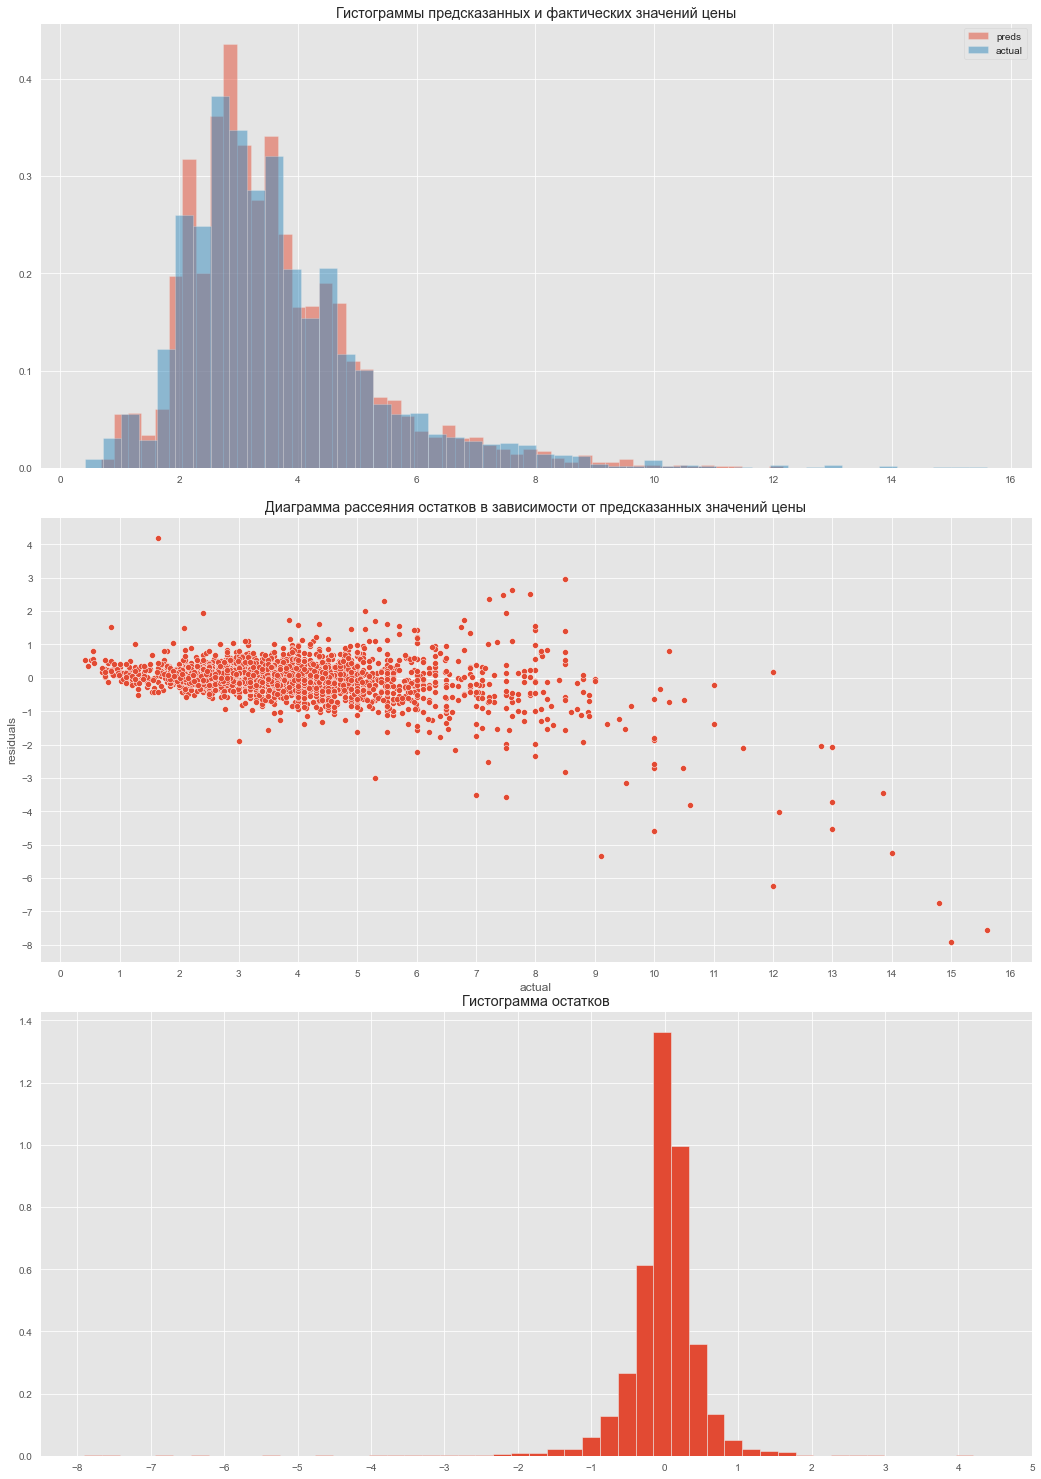

In [27]:
fig, ax = plt.subplots(3, 1, figsize = (15, 21))
plt.tight_layout(pad = 3)
ax[0].hist(np.exp(predictions_best['preds'].tolist())/10**6, bins = 50, alpha = 0.5, density = True, label = 'preds', \
           stacked = True);
ax[0].hist(data_train['price']/10**6, bins = 50, alpha = 0.5, density = True, label = 'actual', stacked = True);
ax[0].set_title('Гистограммы предсказанных и фактических значений цены')
ax[0].legend()

sns.scatterplot(y = (np.exp(predictions_best['preds'].tolist()) - data_train['price'])/10**6, \
                x = data_train['price']/10**6, ax = ax[1]);
ax[1].set_title('Диаграмма рассеяния остатков в зависимости от предсказанных значений цены')
ax[1].set_xlabel('actual')
ax[1].set_ylabel('residuals')
ax[1].set_xticks(range(17))
ax[1].set_yticks(range(-8, 5))

ax[2].hist((np.exp(predictions_best['preds'].tolist()) - data_train.price)/10**6, bins = 50, density = True, \
           stacked = True);
ax[2].set_title('Гистограмма остатков')
ax[2].set_xticks(range(-8, 6))
plt.show()

Гипотеза о совпадении функций распределений фактических и предсказанных цен не отвергается.

In [28]:
scipy.stats.ks_2samp(np.exp(predictions_best['preds'].tolist()), data_train['price'])

KstestResult(statistic=0.019666666666666666, pvalue=0.6076142836051144)

Но отвергается гипотеза о нормальности остатков, чего и следовало ожидать после их визуального анализа.

In [29]:
scipy.stats.anderson((np.exp(predictions_best['preds'].tolist()) - data_train.price))

AndersonResult(statistic=151.9330273365822, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

В среднем модель ошибается на ~ **325 000** рублей, среднеквадратическое отклонение ошибки - **488 824**.

In [30]:
print((np.abs(np.exp(predictions_best['preds'].tolist()) - data_train['price'])).mean())
print((np.abs(np.exp(predictions_best['preds'].tolist()) - data_train['price'])).std())

325590.4908468457
488824.93721278955


В **81.97%** случаев модель ошибается не более чем на **500 000** рублей, в **4.67%** случаев ошибается более чем на **1 000 000** рублей.

In [32]:
print('\033[1m' + \
      str(round(scipy.stats.percentileofscore(np.abs(np.exp(predictions_best['preds'].tolist()) - \
                                                     data_train['price'])/10**6 , \
                                              0.5), 2)) + '% квантиль ошибки:' + '\033[0m', '0.5 млн. руб.', '\n'
      '\033[1m' + \
      str(round(scipy.stats.percentileofscore(np.abs(np.exp(predictions_best['preds'].tolist()) - \
                                                     data_train['price'])/10**6 , \
                                              1), 2)) + '% квантиль ошибки:' + '\033[0m', '1 млн. руб.')

81.97% квантиль ошибки: 0.5 млн. руб. 
95.33% квантиль ошибки: 1 млн. руб.


Сравним гистограммы некоторых признаков наблюдений, ошибка для которых составила более 1 млн.руб. (всего таких 140 штук) с гистограммами тех же переменных для всех наблюдений. Как было выяснено ранее, модель чаще ошибается на дорогостоящих квартирах. Судя по полученным графикам, ей также сложно определять цену квартир с относительно высокой площадью и домами, построенными приблизительно с 1990 по 2010 годы.

В целом тот факт, что значительный разброс оценок (и ошибок соответственно) наблюдается для квартир стоимостью более 7 млн.руб. может происходить как из-за того, что они составляют лишь незначительную часть выборки (всего 140 наблюдений) и данных по ним слишком мало, чтобы находить закономерности и усреднения, так и из-за того, что цены в их объявлениях о продаже чересчур завышены и могут быть классифицированы как выбросы, если же избавиться от большинства таких объектов в обучающей выборке, качество результатов, вероятно, должно вырасти.

Могло случиться и так, что среди объясняющих переменных, описывающих объявление о продаже, нет таких, с помощью которых можно было бы достоверно отличать доорогостоящую недвижимость, кроме очевидной общей площади, которой, судя по полученным ошибкам, не хватает для формирования адекватной оценки таких квартир. Если посмотреть на признаки, то большинство числовых среди них являются географическими, но дорогие квартиры (больше 7-8 млн. руб. для Абакана) вряд ли отличаются по расположению от квартир средней стоимости (~4 млн.руб.), а остальные данные, описывающие саму квартиру, или зачастую имеют много пропусков, или представляют собой слишком расплывчатые категории.

Возьмем, например, тип ремонта в квартире. Существуют ли какие-то формальные различия между косметическим/дизайнерским/евроремонтом на сайтах-агрегаторах объявлений? Скорее всего, нет, одна и та же категория может содержать как новую раковину/красивые обои, которые рекламодатель посчитает евроремонтом, так и действительно дорогой ремонт, который мог составить значительную часть стоимости квартиры. Аналогичные рассуждения можно привести и для других, описывающих внутренности квартиры переменных (мебель, кондиционер, количество комнат).

В общем, я не слишком удивлен высоким ошибкам у дорогостоящей (относительно большей части выборки) недвижимости. Выборке категорически не хватает качественных признаков, описывающих внутреннюю составляющую жилплощади, которые, собственно, и нет возможности откуда-то достать, за исключением фотографий помещений и планировки, но и они слишком зависят от усилий, которые агент готов приложить для того, чтобы продать квартиру.

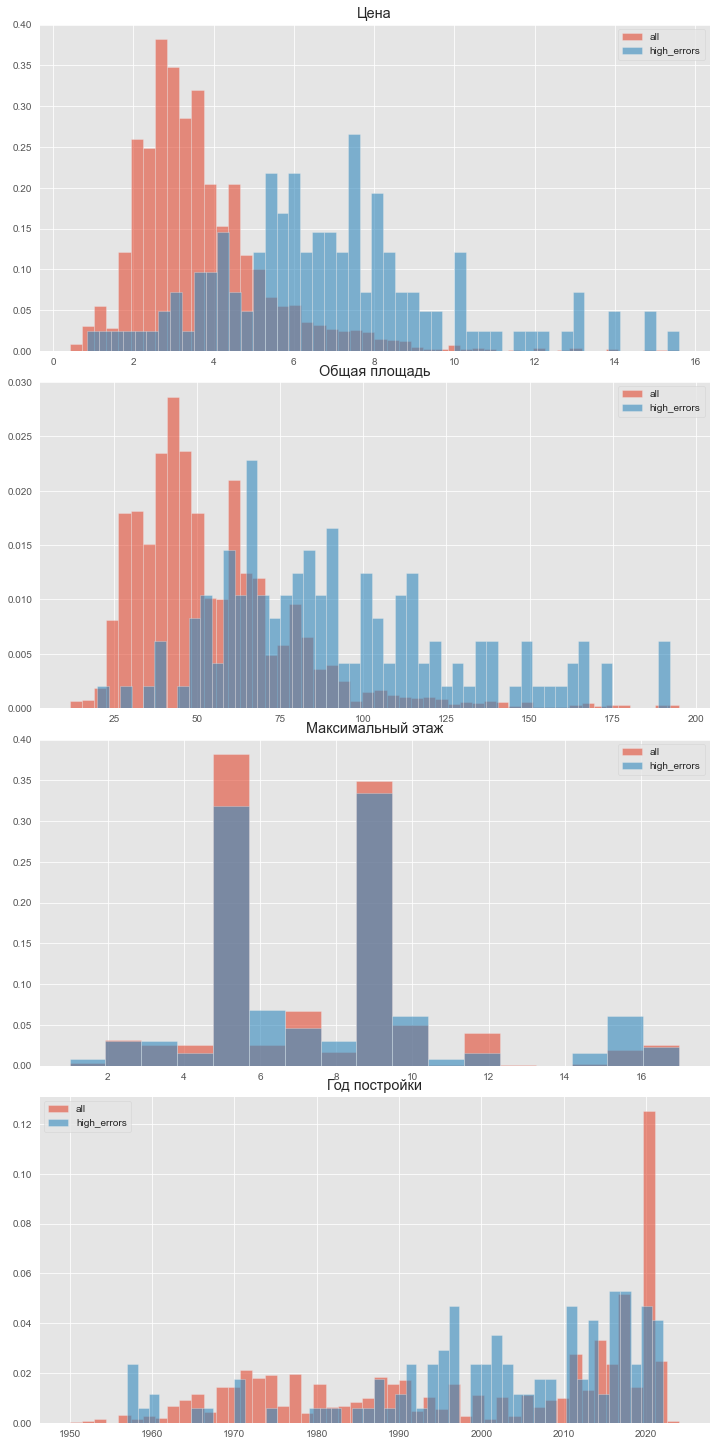

In [33]:
fig, ax = plt.subplots(4, 1, figsize = (10, 20))
plt.tight_layout()
ax[0].hist((data_train.price/10**6), bins = 50, density = True, alpha = 0.6, label = 'all');
ax[0].hist(data_train.loc[np.abs(np.exp(predictions_best['preds'].tolist()) - data_train['price']) > 1*10**6] \
 .price/10**6, bins = 50, density = True, alpha = 0.6, label = 'high_errors');
ax[0].set_title('Цена')
ax[0].legend()

ax[1].hist((data_train.total_square), bins = 50, density = True, alpha = 0.6, label = 'all');
ax[1].hist(data_train.loc[np.abs(np.exp(predictions_best['preds'].tolist()) - data_train['price']) > 1*10**6] \
.total_square, bins = 50, density = True, alpha = 0.6, label = 'high_errors');
ax[1].set_title('Общая площадь')
ax[1].legend()

ax[2].hist((data_train.max_floor), bins = 17, density = True, alpha = 0.6, label = 'all');
ax[2].hist(data_train.loc[np.abs(np.exp(predictions_best['preds'].tolist()) - data_train['price']) > 1*10**6] \
.max_floor, bins = 17, density = True, alpha = 0.6, label = 'high_errors');
ax[2].set_title('Максимальный этаж')
ax[2].legend()

ax[3].hist((data_train.year), bins = 50, density = True, alpha = 0.6, label = 'all');
ax[3].hist(data_train.loc[np.abs(np.exp(predictions_best['preds'].tolist()) - data_train['price']) > 1*10**6] \
.year, bins = 50, density = True, alpha = 0.6, label = 'high_errors');
ax[3].set_title('Год постройки')
ax[3].legend()

plt.show()

Обучим лучшую модель на всех доступных данных, за исключением тестового сета. Все параметры у *CatBoostRegressor* выбираются автоматически, то есть из наиболее важных:
* **1000** деревьев
* Деревья **симметричны**
* Скорость сходимости **0.047**
* Максимальная глубина **6**
* Коэффициент l2-регуляризации **3**
* **Нет ограничений** на минимальное число объектов в листовой вершине и максимальное число вершин

In [34]:
aaa = np.array(starter_bstr.loc[1, 'features'])

train, test, val = processing(scaler = None, cv = True, index_train = pd.Index(range(0, 3000)), \
                              index_test = pd.Index(range(0, 3000)))

X_train = train.drop(['price', 'kitchen_log_meaned', 'total_log', 'kitchen_log_medianed'], axis = 1)
X_val = val.drop(['price', 'kitchen_log_meaned', 'total_log', 'kitchen_log_medianed',], axis = 1)
X_train[X_val.columns.difference(X_train.columns)] = 0
X_val[X_train.columns.difference(X_val.columns)] = 0
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_val = X_val.loc[:, ~X_val.columns.duplicated()]
y_train = np.log(train.price)
y_val = np.log(val.price)

feat_use = aaa[(aaa != 'year_freq') & (aaa != 'year_medianed') & (aaa != 'kitchen_square_meaned') & \
               (aaa != 'rooms') & (aaa != 'rooms_v1') & (aaa != 'rooms_v2')].tolist()
X_train = X_train.loc[:, feat_use]
X_val = X_val.loc[:, feat_use]

bstr = ctb.CatBoostRegressor(iterations = 1000, 
                             depth = 6, 
                             learning_rate = 0.04746000096201897,
                             random_strength = 1,
                             border_count = 254,
                             l2_leaf_reg = 3, 
                             grow_policy = 'SymmetricTree',
                             cat_features = list(X_train.columns[X_train.dtypes == 'O']),
                             random_state = 42)
bstr.fit(X_train, y_train, verbose = False)

С помощью библиотеки **shap** построим дополнительные интерпретации объясняющих переменных. На графике ниже представлено влияние общей площади квартиры на ее стоимость. Можно заметить, что с ростом *общей площади* растет и прогноз стоимости квартиры, однако эта зависимость не является линейной. 

Кроме того, **shap** автоматически определяет *количество туристических объектов в радиусе 100 метров* как наиболее связанный с *площадью* признак, при этом увеличение числа таких объектов, скорее всего, несколько снижает влияние площади на стоимость.

In [36]:
shap.initjs()

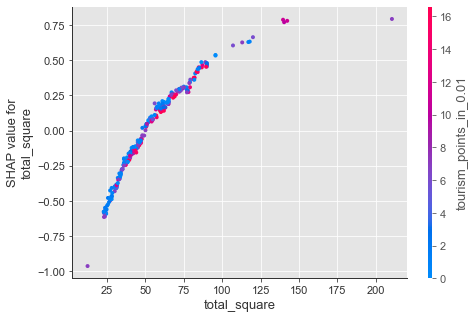

In [39]:
explainer = shap.TreeExplainer(bstr)
shap_values = explainer.shap_values(X_val)
shap.dependence_plot("total_square", shap_values, X_val)

Теперь взглянем на график влияния остальных переменных на цену квартиры. Здесь из примечательного:
1. Ни одна из переменных так сильно не позволяет различать цены на квартиры, как площадь (если посмотреть на значения *shap values* по оси X для нижнего графика, большая часть из них сосредоточены в интервале от **-0.1** до **0.1**, тогда как у площади интервал от **-0.75** до **0.75**)
2. Тем не менее, суммарный вклад представленных признаков для модели все-таки довольно значителен
3. Между многими фичами и их влиянием на отклонение прогноза от бейзлайна есть однозначная однонаправленная зависимость:
* Положительная для *года постройки*, *высотности здания*, *точек общепита, туристических и парковочных объектах в радиусе 100 метров*, *объектов удобства в радиусе 500 метров*, *числа комнат/лоджий/балконов* и других
* Отрицательная для *долготы* (хотя там много значений, никак не влияющих на прогноз), *количества зданий в радиусе 500 метров*, *объектов природы в радиусе одного километра*

4. Из числа категориальных переменных влияние на стоимость имеют три из четырех категорий в *ремонте квартиры* (положительное у *евроремонта* и *дизайнерского*, отрицательное у *без ремонта*, *косметический ремонт* не влияет), а также одна категория в *парковке* (положительное у *подземной*).
5. Помогают разделить объекты по стоимости не только обычные дамми-переменные (*мебель* и *кондиционер*), но и связанные с тем, было ли значение признака пропущено в первоначальной выборке, например, для *года постройки*, *вида из окна*, *лифта*

Интересен также тот факт, что большая часть переменных, которая имела низкие/отрицательные важности, на самом деле, судя по *shap_values*, имеет определенное влияние на стоимость квартир.

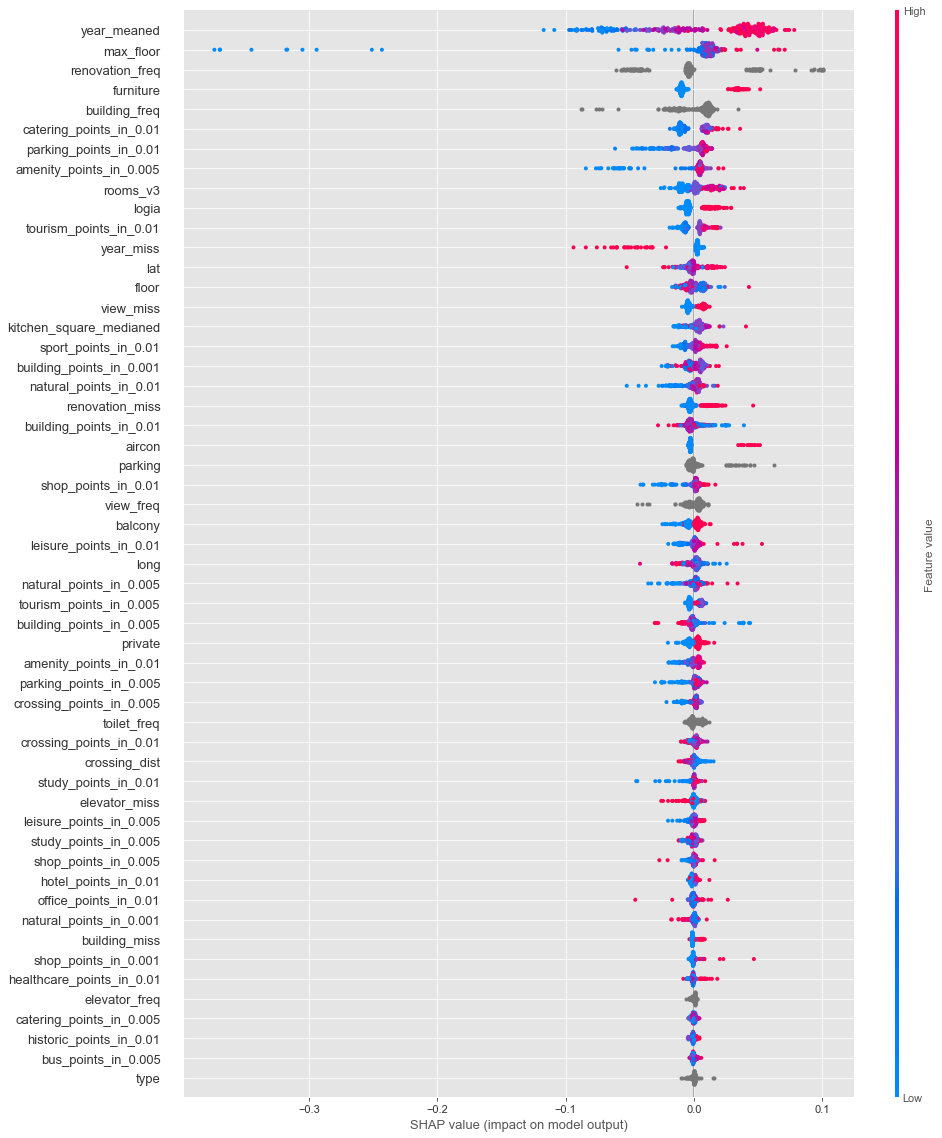

In [40]:
shap.summary_plot(shap_values[:, np.r_[0:2, 3:61]], X_val.iloc[:, np.r_[0:2, 3:61]], max_display = 54, \
                  plot_size = (15, 20))

Оставляю интерактивный график со всевозможными комбинациями **shap values** для залипания.

In [41]:
shap.force_plot(explainer.expected_value, shap_values, X_val)

## Результат

На этом построение моделей и проект в целом завершается. Можно было бы постакать или надобавлять в модель новые сгенерированные полиномиально/арифмитическими операциями/таргет-кодированием категорий/иными способами признаки, но не очень хочется гоняться за скором, все-таки медальку за него не дают, а интерпритируемость моделей терять не очень хочется.

Лучшей моделью (ожидаемо) оказался градиентный бустинг с **RMSE**, равной **0.1266** для логарифмированных цен, то есть в среднем модель ошибается на ~**13.5%** (*exp(RMSE)*). Если перевести прогнозы в уровни и посчитать метрику, то получим следующее (тут нужно помнить о том, что минимизация **MSE** для логарифма таргета на самом деле ведет к минимизации **MAE** для таргета в уровнях и получению медианных предсказаний вместо средних, о чем подробнее можно почитать, например, [здесь](https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/)):

In [94]:
mae = sklearn.metrics.mean_absolute_error(np.exp(predictions_best.iloc[:, 0].tolist()), data_train.price)
print('Средняя абсолютная ошибка прогноза составляет', '\033[1m' + \
      str(int(sklearn.metrics.mean_absolute_error(np.exp(predictions_best.iloc[:, 0].tolist()), data_train.price))) + \
      '\033[0m рублей.')

Средняя абсолютная ошибка прогноза составляет 325590 рублей.


Что в общем-то является довольно большой ошибкой (10% от средней стоимости квартир в выборке), но не нужно забывать о том, что цены в объявлениях зачастую не являются реальными показателями стоимости недвижимости, так что ожидать здесь результатов лучше, скорее всего, и не стоило. Модель не сможет найти закономерности там, где их на самом деле нет, или они слишком зашумлены случайными изменениями, которые появляются из-за субъективных оценок рекламодателей, а для получения мудрости толпы в задаче не совсем хватает наблюдений, особенно для дорогих объектов недвижимости.

## Чего не хватает этому ноутбуку и проекту в целом

* Не хватает кода здорового человека в файле с функциями, потому что на данный момент там можно нередко встретить код курильщика. Варианта его развития мне видятся два: во-первых, можно отказаться от идеи писать все самому и создать реализацию через скайлерновские пайплайны, что точно должно повысить скорость обучения моделей. Можно пойти по более хардкорному пути и запилить один большой класс для всех моделей, внутри которого будет производиться и обучение, и отбор признаков для всевозможных параметров, вариантов датасетов и спецификаций регрессий, но на данный момент моего уровня написания кода для этого точно не достаточно, но когда-нибудь я постараюсь добить задуманное.
* Дополнительных выборок. Те данные, что используются в проекте, были собраны чуть больше месяца назад, и с тех пор, на агрегаторах точно появились новые наблюдения, с помощью которых возможно как обогатить датасет, так и использовать их в качестве отложенной тестовой выборки. В случае их появления через определенное время, однако, точно понадобится учет временной составляющей и, скорее всего, прикручивание дополнительных внешних переменных, таких, например, как инфляция/ставки по ипотекам/процентные ставки.
* Продвинутых техник работы с пропусками. Пропусков много, но переменные с ними от этого, как показала практика, не становятся менее важными для моделей. Поэтому здесь напрашиваются какие-то более интересные варианты заполнения пропусков, чем простые imputer-ы, например, с помощью KNN, MICE и т.д.
* Интересных альтернативных подходов. Все, что было мной реализовано при внедрении регрессий, является довольно базовыми действиями при построении моделей, но я пока не уверен, что конкретно можно было бы добавить. После участия в [хакатоне от райфа](https://raifhack.ru/) (где мы улетели с 25 места на паблике на 60 на привате из-за оверфита лидерборда, хотя среди наших коммитов были модели, которые бы зашли в топ-20), где нужно было оценивать стоимость коммерческой недвижимости, а основная фишка состояла в том, что значительная масса наблюдений являлись объявлениями с агрегаторов, тогда как небольшая часть и, собственно, тестовая выборка, которую нужно было предсказывать, являлись ручными оценками экспертов, мне приходила в голову идея попробовать использовать объявления от риэлторских агентств в качестве таких же фактических цен, а объявления от частников как дополнительную выборку. Проблема состояла в том, что лучшими подходами на хакатоне оказались те, что просто избавлялись от всех наблюдений, кроме оцененных экспертами, а выкидывать половину выборки совсем не хотелось, да и каких-то реальных причин того, почему риэлторы вдруг стали выкладывать близкую к фактической стоимости цену в объвлении я найти не смог (все-таки гипотеза о совпадении законов распределения цен в выборках для риэлторов и частников не отвергалась).
* Тюнинга параметров. Честно говоря, я был немного огорчен тем, что не удалось улучшить результаты моделей с помощью изменения гиперпараметров. Причина, по моему мнению, кроется или в неверно рассматриваемых границах поиска, или в неудачных сидах и малом количестве комбинаций у случайного перебора, хотя те результаты, что представлены в ноутбуке не являются единственными, перебор повторялся еще для нескольких случайных состояний, но прироста в метриках это не дало. Если здесь все-таки появятся пайплайны, то нужно попробовать вместо случайного использовать Байесовский поиск по фолдам.
* Других вариантов градиентного бустинга. Я привык работать с CatBoost и LightGBM, а в задаче много категориальных переменных, так что сразу напрашивался CatBoost, которые обычно дает результаты лучше, чем LightGBM. Но не исключаю того, что и он, и XGBoost при должной настройке гиперпараметров, могли бы потенциально улучшить скор.